# DESI mini end-to-end test

Test end-to-end dataflow using a small number of tiles.<BR/>
pre-testing for 20.7 release, July 2020.

In [1]:
minitest_version = '20.7'

## Basic setup to run this yourself at NERSC
On cori.nersc.gov, clone desitest:
```
git clone https://github.com/desihub/desitest
```
If needed, checkout the branch with the version you'd like to test, e.g.:
```
cd desitest
git checkout automini
```
This notebook and its configuration files are in desitest/mini.

Configure the desi test-release jupyter notebook kernel for your account following the instructions at https://desi.lbl.gov/trac/wiki/Computing/JupyterAtNERSC. Then go to https://jupyter.nersc.gov, navigate to where you checked out desitest/mini and start your own copy of this notebook.
To get the same version of code with an interactive login:
```
source /project/projectdirs/desi/software/desi_environment.sh master
```
(or desi_environment.csh for t/csh users)

## Running this notebook

Some steps of this notebook directly spawn batch jobs and wait for them to finish. These steps log to a different file so that the notebook isn't cluttered with N>>1 lines of output. Steps that take more than a few minutes should indicate how long they expect to take and when they started. Go check the logfile and/or run `squeue -u $USER` from a command line to check on things if you think they are stuck.

If everything runs successfully with minimal queue wait times, the entire notebook should run end-to-end in about 2 hours. Each step automatically recognizes whether it has already been successfully run and skips expensive processing steps if they aren't needed. Thus if you need to restart, you can always just start from the very beginning and it will quickly catch up to the next substantive step to do.

If you want to force reprocessing of everything, remove the minitest directory from `$SCRATCH/` (see the `minitest_version` variable defined above) and then restart the notebook from the beginning.

This notebook will take ~1500 MPP hours at NERSC. Check your balance at https://nim.nersc.gov to make sure you have enough before starting.

In [2]:
# This should always be first because calling it later can screw up the namespace.
import desitarget

%pylab inline

import os, sys, glob, time, subprocess, time, shutil
import numpy as np
import healpy as hp
from astropy.table import Table, join
from astropy.io import fits
import fitsio
#- Some of these are imported just to establish versions
#- but aren't used in the notebook itself
import desisim
import desispec.io
from desispec.scripts import pipe
import desitarget.io
from desitarget.targetmask import desi_mask
import desimodel.io
import desimodel.footprint
import desisurvey
import surveysim
import specsim
from surveysim.util import add_calibration_exposures
import desiutil.depend
import specter
import redrock
import simqso

print("Starting at {}".format(time.asctime()))
notebook_start_time = time.time()

Populating the interactive namespace from numpy and matplotlib
Starting at Tue Aug  4 22:13:52 2020


## Define the code versions used for this notebook

In [3]:
print(os.environ['DESIMODULES'])

deps = dict()

desiutil.depend.add_dependencies(deps)
desiutil.depend.setdep(deps, 'simqso', simqso.__version__)

for p in ('dust', 'desimodules'):
    if p.upper()+'_VERSION' in os.environ:
        desiutil.depend.setdep(deps, p, os.environ[p.upper()+'_VERSION'])

for codename, version in desiutil.depend.iterdep(deps):
    print('  {:12s} {}'.format(codename, version))

/global/common/software/desi/cori/desiconda/startup/modulefiles/desimodules
  python       3.8.3
  numpy        1.19.1
  scipy        1.5.0
  astropy      4.0.1.post1
  yaml         5.3.1
  matplotlib   3.2.1
  fitsio       1.1.2
  healpy       1.14.0
  desiutil     3.0.3
  desispec     0.34.6
  desitarget   0.41.0
  desimodel    0.13.0
  desisim      0.35.3
  desisurvey   0.14.0
  specter      0.9.4
  speclite     0.9
  specsim      0.14
  surveysim    0.12.0
  redrock      0.14.4
  simqso       1.2.4
  dust         v0_1
  desimodules  test-20.7


## Set some environment variables and create output directories

The next cell will create directories under `$SCRATCH/` and set environment variables for this mapping:

| Directory             | NB variable   | Environment Variable                              |
|-----------------------|---------------|---------------------------------------------------|
| survey/               | surveydir     | `$DESISURVEY_OUTPUT`                              |
| targets/              | targetdir     |                                                   |
| fiberassign/          | fibassigndir  |                                                   |
| spectro/redux/mini/   | reduxdir      | `$DESI_SPECTRO_REDUX/$SPECPROD`                   |
| spectro/sim/mini/     | simdatadir    | `$DESI_SPECTRO_DATA = $DESI_SPECTRO_SIM/$PIXPROD` |

It additionally derives the location of the base directory as the notebook
variable `minitestdir` for use in later cells.


In [4]:
basedir      = os.path.join(os.environ['SCRATCH'], 'minitest-'+minitest_version)

surveydir    = os.environ['DESISURVEY_OUTPUT'] = os.path.join(basedir, 'survey')
targetdir    = os.path.join(basedir, 'targets')
fibassigndir = os.path.join(basedir, 'fiberassign')
minitestdir  = os.getcwd()

desimodules_version = os.environ['DESIMODULES_VERSION']

os.environ['DESI_SPECTRO_REDUX'] = os.path.join(basedir, 'spectro', 'redux')
os.environ['DESI_SPECTRO_SIM']   = os.path.join(basedir, 'spectro', 'sim')
os.environ['PIXPROD']  = 'mini'
os.environ['SPECPROD'] = 'mini'

# os.environ['DESI_CCD_CALIBRATION_DATA'] = os.getenv('DESI_ROOT')+'/spectro/ccd_calibration_data/trunk/'

reduxdir   = os.path.join(os.environ['DESI_SPECTRO_REDUX'], os.environ['SPECPROD'])
simdatadir = os.path.join(os.environ['DESI_SPECTRO_SIM'], os.environ['PIXPROD'])

os.environ['DESI_SPECTRO_DATA'] = simdatadir

os.makedirs(surveydir, exist_ok=True)
os.makedirs(targetdir, exist_ok=True)
os.makedirs(fibassigndir, exist_ok=True)
os.makedirs(reduxdir, exist_ok=True)
os.makedirs(simdatadir, exist_ok=True)

if 'csh' in os.environ['SHELL']:
    envcmd = "source /project/projectdirs/desi/software/desi_environment.csh {}".format(desimodules_version)
    envcmd += """
set basedir = ${basedir}
setenv DESISURVEY_OUTPUT ${basedir}/survey
setenv DESI_SPECTRO_REDUX ${basedir}/spectro/redux
setenv DESI_SPECTRO_SIM ${basedir}/spectro/sim
setenv SPECPROD mini
setenv PIXPROD mini
setenv DESI_SPECTRO_DATA ${DESI_SPECTRO_SIM}/${PIXPROD}
setenv DESI_CCD_CALIBRATION_DATA ${DESI_ROOT}/spectro/ccd_calibration_data/trunk/
"""
else:
    envcmd = "source /project/projectdirs/desi/software/desi_environment.sh {}\n".format(desimodules_version)
    envcmd += "basedir={}".format(basedir)
    envcmd += """
export DESISURVEY_OUTPUT=${basedir}/survey
export DESI_SPECTRO_REDUX=${basedir}/spectro/redux
export DESI_SPECTRO_SIM=${basedir}/spectro/sim
export SPECPROD=mini
export PIXPROD=mini
export DESI_SPECTRO_DATA=${DESI_SPECTRO_SIM}/${PIXPROD}
export DESI_CCD_CALIBRATION_DATA=${DESI_ROOT}/spectro/ccd_calibration_data/trunk/
"""

setupfile = os.path.join(basedir, 'setup.sh')
with open(setupfile, 'w') as fx:
    fx.write(envcmd)
    
print('To recreate this environment from a login terminal:\n')
# print(basedir)
print(envcmd)

print('or\n')
print('source {}'.format(setupfile))

To recreate this environment from a login terminal:

source /project/projectdirs/desi/software/desi_environment.sh test-20.7
basedir=/global/cscratch1/sd/sjbailey/minitest-20.7
export DESISURVEY_OUTPUT=${basedir}/survey
export DESI_SPECTRO_REDUX=${basedir}/spectro/redux
export DESI_SPECTRO_SIM=${basedir}/spectro/sim
export SPECPROD=mini
export PIXPROD=mini
export DESI_SPECTRO_DATA=${DESI_SPECTRO_SIM}/${PIXPROD}
export DESI_CCD_CALIBRATION_DATA=${DESI_ROOT}/spectro/ccd_calibration_data/trunk/

or

source /global/cscratch1/sd/sjbailey/minitest-20.7/setup.sh


## Define a subset of tiles to use

In [5]:
alltiles = Table(desimodel.io.load_tiles())

#- Does tile subset already exist from an earlier run?
tilefile = os.path.join(surveydir, 'test-tiles.fits')
if os.path.exists(tilefile):
    print('Reading {}'.format(tilefile))
    tiles = Table.read(tilefile)
else:
    #- Make a subset of tiles to use
    ii = (149 < alltiles['RA']) & (alltiles['RA']<151) & (30<alltiles['DEC']) & (alltiles['DEC']<32)
    tiles = Table(alltiles[ii])

    #- Write two copies:
    #- one in two_percent_DESI/mini because that is where the surveysim config file will look, and
    #- one in $surveydir/ for later use by mpi_select_mock_targets
    tiles.write('test-tiles.fits', overwrite=True)
    tiles.write(tilefile, overwrite=True)

#- Show what tiles are in the subset
tiles

Reading /global/cscratch1/sd/sjbailey/minitest-20.7/survey/test-tiles.fits


<Table length=8>
TILEID         RA                DEC         ... IMAGEFRAC_GRZ IN_IMAGING
int32       float64            float64       ...    float32     float32  
------ ------------------ ------------------ ... ------------- ----------
  5346 149.54296515799953  31.82422737037591 ...    0.97601604        1.0
 11108  150.4377629274328 31.483639342687276 ...     0.9826684        1.0
 16870 149.88176540349662 30.416033191146457 ...     0.9983053        1.0
 22632 149.77999999999997              31.25 ...     0.9897933        1.0
 28394 149.25750651107094  31.27610009579035 ...     0.9960003        1.0
 34156 149.25750651107094  31.27610009579035 ...     0.9960003        1.0
 39918 149.54296515799953  31.82422737037591 ...    0.97601604        1.0
 45680  150.4377629274328 31.483639342687276 ...     0.9826684        1.0

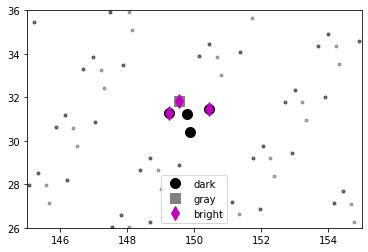

In [6]:
#- Plot those tiles
clf()
plot(alltiles['RA'], alltiles['DEC'], 'k.', alpha=0.3, label='_none_')
isdark = tiles['PROGRAM'] == 'DARK'
isgray = tiles['PROGRAM'] == 'GRAY'
isbright = tiles['PROGRAM'] == 'BRIGHT'
plot(tiles['RA'][isdark], tiles['DEC'][isdark], 'o', color='k', ms=10, label='dark')
plot(tiles['RA'][isgray], tiles['DEC'][isgray], 's', color='0.5', ms=10, label='gray')
plot(tiles['RA'][isbright], tiles['DEC'][isbright], 'd', color='m', ms=10, label='bright')
xlim(145, 155); ylim(26, 36)
legend()

## Run survey simulations on the subset of tiles

This will select a test subset of tiles in the NGC and run survey simulations for observations during March 2020.  These steps should take <5 minutes to run.

In [7]:
orig_configfile = os.path.join(minitestdir, 'desisurvey-config.yaml')
configfile = os.path.join(surveydir, 'desisurvey-config.yaml')
shutil.copy(orig_configfile, configfile)

if os.path.exists(surveydir + '/surveyinit.fits'):
    print('surveyinit.fits already exists; skipping surveyinit')
else:
    logfilename = os.path.join(surveydir, 'surveyinit.log')
    cmd = 'surveyinit --config-file {} --init zero --max-cycles 0'.format(configfile)
    print('Running {}'.format(cmd))
    print('Starting at {}; should take ~2 minutes'.format(time.asctime()))
    with open(logfilename, 'a') as logfile:
        err = subprocess.call(cmd.split(), stderr=logfile, stdout=logfile)
        if err != 0:
            print('surveyinit failed err={}; see {}'.format(err, logfilename))
            raise RuntimeError
        else:
            print('done at {}'.format(time.asctime()))

surveyinit.fits already exists; skipping surveyinit


In [8]:
surveysim_expfile = os.path.join(surveydir, 'exposures_surveysim.fits')
if os.path.exists(surveysim_expfile):
    print('Survey sims already done; skipping')
else:
    logfilename = os.path.join(surveydir, 'surveysim.log')
    cmd = 'surveysim --config-file {} --save-restore'.format(configfile)
    print('Running {}'.format(cmd))
    print('Starting at {}; takes a few minutes'.format(time.asctime()))
    with open(logfilename, 'a') as logfile:
        err = subprocess.call(cmd.split(), stderr=logfile, stdout=logfile)
        if err != 0:
            print('surveysim failed err={}; see {}'.format(err, logfilename))
            raise RuntimeError
        else:
            print('done at {}'.format(time.asctime()))

Survey sims already done; skipping


### Confirm that we got the expected output files before proceeding

In [9]:
if not os.path.exists(surveysim_expfile):
    print("ERROR: Missing {}".format(expfile))
    print("Check {} for what might have gone wrong".format(survey_logname))
    print()
    
print('Files in {}:\n'.format(surveydir))
!ls $surveydir

Files in /global/cscratch1/sd/sjbailey/minitest-20.7/survey:

desi-status-20200315.fits  desi-status-20200402.fits
desi-status-20200316.fits  desi-status-20200403.fits
desi-status-20200317.fits  desi-status-20200404.fits
desi-status-20200318.fits  desi-status-20200405.fits
desi-status-20200319.fits  desi-status-20200406.fits
desi-status-20200320.fits  desi-status-20200407.fits
desi-status-20200321.fits  desi-status-20200408.fits
desi-status-20200322.fits  desi-status-20200409.fits
desi-status-20200323.fits  desi-status-20200410.fits
desi-status-20200324.fits  desisurvey-config.yaml
desi-status-20200325.fits  ephem_2019-01-01_2025-12-31.fits
desi-status-20200326.fits  exposures.fits
desi-status-20200327.fits  exposures_surveysim.fits
desi-status-20200328.fits  stats_surveysim.fits
desi-status-20200329.fits  surveyinit.fits
desi-status-20200330.fits  surveyinit.log
desi-status-20200331.fits  surveysim.log
desi-status-20200401.fits  test-tiles.fits


### Add calibration exposures and extra columns from tiles table

In [10]:
expfile = os.path.join(surveydir, 'exposures.fits')
explist_lite = Table.read(surveysim_expfile, 'EXPOSURES')
explist = surveysim.util.add_calibration_exposures(explist_lite)

INFO:tiles.py:319:get_tiles: Initialized tiles from "desi-tiles.fits".
INFO:tiles.py:324:get_tiles: DARK   passes(tiles): 1(1998), 2(1998), 3(1998), 4(1998).
INFO:tiles.py:324:get_tiles: GRAY   passes(tiles): 0(1998).
INFO:tiles.py:324:get_tiles: BRIGHT passes(tiles): 5(1998), 6(1998), 7(1998).
INFO:util.py:129:add_calibration_exposures: Added 6 nightly calibration sequences of 6 exposures each to 21 science exposures.


In [11]:
print(explist_lite.colnames)
print(explist.colnames)

['EXPID', 'MJD', 'EXPTIME', 'TILEID', 'SNR2FRAC', 'AIRMASS', 'SEEING', 'TRANSP', 'SKY']
['EXPID', 'MJD', 'EXPTIME', 'TILEID', 'SNR2FRAC', 'AIRMASS', 'SEEING', 'TRANSP', 'SKY', 'PROGRAM', 'NIGHT', 'FLAVOR', 'MOONFRAC', 'MOONALT', 'MOONSEP']


The default MOONALT, MOONSEP, and MOONFRAC columns are data model placeholders
but not filled in with meaningful values.  Correct that.  Notes:
* the code below is approximate (but still better than using MOONALT=-10 for BRIGHT exposures)
* surveysim doesn't currently vary the bright exposure time for lunar parameters (!), so filling
  this in with actual parameters instead of median defaults is arguably the wrong thing to do,
  but it does give us a variation of conditions from which one could how the exposure times
  should vary.

In [12]:
import desisurvey.ephem
import warnings
warnings.filterwarnings('ignore', message=r'Tried to get polar motions for times after IERS data')

def add_moon_params(explist):
    '''Fills MOONFRAC, MOONALT, MOONSEP columns in explist'''    

    ephem_file = glob.glob(surveydir + '/ephem*.fits')[0]
    ephem = Table.read(ephem_file)
    
    explist['MOONFRAC'] = np.interp(explist['MJD'], ephem['brightdusk'], ephem['moon_illum_frac'])

    ii = np.searchsorted(ephem['brightdusk'], explist['MJD'])-1
    assert np.all(ii>=0)
    for i, j in zip(ii, range(len(explist['MJD']))):
        if explist['FLAVOR'][j] != 'science':
            continue
        moon = desisurvey.ephem.get_object_interpolator(ephem[i], 'moon', altaz=True)
        mjd = explist['MJD'][j]
        explist['MOONALT'][j] = moon(mjd)[0]
        moon_dec, moon_ra = desisurvey.ephem.get_object_interpolator(ephem[i], 'moon', altaz=False)(mjd)        
        phi1, phi2 = np.radians(moon_dec), np.radians(explist['DEC'][j])
        theta1, theta2 = np.radians(moon_ra), np.radians(explist['RA'][j])
        #- Haversine formula
        d = 2*np.arcsin(np.sqrt(np.sin(0.5*(phi2-phi1))**2 + np.cos(phi1)*np.cos(phi2)*np.sin(0.5*(theta2-theta1))**2))
        # print(np.degrees([phi1, phi2, theta1, theta2]), np.degrees(d))
        explist['MOONSEP'][j] = np.degrees(d)

In [13]:
#- Prevent astropy from crashing because it can't download the latest IERS data
#- to calculate the location of the moon to sub-arcsecond accuracy (!)
from astropy.utils.iers import conf
conf.auto_max_age = None

expfile = os.path.join(surveydir, 'exposures.fits')
if os.path.exists(expfile):
    print('Reading explist from '+expfile)
    explist = Table.read(expfile)
else:
    print('Adding calibration exposures and additional columns to '+surveysim_expfile)
    explist = Table.read(surveysim_expfile, 'EXPOSURES')
    explist = surveysim.util.add_calibration_exposures(explist)
    explist = join(explist, tiles['TILEID', 'RA', 'DEC', 'PASS'], keys='TILEID', join_type='left')
    explist.sort('MJD')

    add_moon_params(explist)

    print('Writing explist to '+expfile)
    explist.meta['EXTNAME'] = 'EXPOSURES'
    explist.write(surveydir+'/exposures.fits', overwrite=True)

Reading explist from /global/cscratch1/sd/sjbailey/minitest-20.7/survey/exposures.fits


In [14]:
explist[explist['FLAVOR'] == 'science']

<Table length=21>
EXPID        MJD         EXPTIME  ...        DEC          PASS
int32      float64       float32  ...      float64       int16
----- ------------------ -------- ... ------------------ -----
    6 58924.112499999996    300.0 ...  31.27610009579035     5
    7   58924.1166666666    300.0 ...  31.27610009579035     5
    8  58924.12152777765    320.0 ...  31.82422737037591     6
    9 58924.125925925735    350.0 ...  31.82422737037591     6
   10 58924.131365740475    270.0 ... 31.483639342687276     7
   11  58924.13518518487    310.0 ... 31.483639342687276     7
   12  58924.36030092626    560.0 ... 31.483639342687276     1
   13  58924.36747685207    630.0 ... 31.483639342687276     1
   20  58926.43611111216    510.0 ... 30.416033191146457     2
   21  58926.44270833428    330.0 ... 30.416033191146457     2
   28  58934.11597222222    570.0 ... 30.416033191146457     2
   29 58934.123263888774 87.50001 ... 30.416033191146457     2
   36  58935.11944444444    950.0 ... 30.416033191146457     2
   37  58935.13113425906    250.0 ... 30.416033191146457     2
   44  58937.11944444444    670.0 ...  31.27610009579035     4
   45  58937.12789351838    460.0 ...  31.27610009579035     4
   46 58937.134606481246    650.0 ...              31.25     3
   47  58937.14282407371    740.0 ...              31.25     3
   54  58951.26840277824    360.0 ...  31.82422737037591     0
   55  58951.27395833372    380.0 ...  31.82422737037591     0
   56 58951.279050926234    690.0 ...  31.82422737037591     0

## Study which healpixels cover those tiles

In [15]:
isbright = explist['PROGRAM'] == 'BRIGHT'
isgray = explist['PROGRAM'] == 'GRAY'
isdark = explist['PROGRAM'] == 'DARK'

(28.0, 37.0)

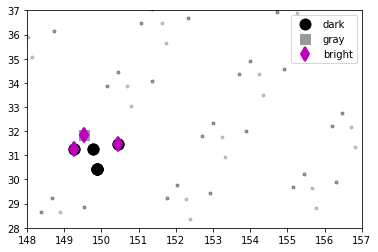

In [16]:
plot(alltiles['RA'], alltiles['DEC'], 'k.', alpha=0.2, label='_none_')
plot(explist['RA'][isdark], explist['DEC'][isdark], 'o', color='k', ms=10, mew=2, label='dark')
plot(explist['RA'][isgray], explist['DEC'][isgray], 's', color='0.6', ms=10, label='gray')
plot(explist['RA'][isbright], explist['DEC'][isbright], 'd', color='m', ms=10, mew=2, label='bright')
legend(loc='upper right')
xlim(148, 157); ylim(28, 37)

In [17]:
nside = 64
pixels = desimodel.footprint.tiles2pix(nside, tiles)
nexp = np.count_nonzero(np.in1d(explist['TILEID'], tiles['TILEID']))
print('{} tiles covered by {} exposures and {} healpixels'.format(len(tiles), nexp, len(pixels)))

8 tiles covered by 21 exposures and 26 healpixels


In [18]:
pixels

array([5262, 5263, 5281, 5283, 5284, 5285, 5286, 5287, 5289, 5291, 5292,
       5293, 5294, 5295, 5296, 5297, 5298, 5299, 5304, 5305, 5306, 5307,
       5633, 5636, 5637, 5648])

(28.0, 37.0)

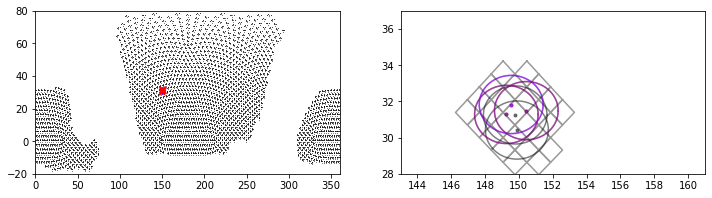

In [19]:
def plot_tile(ra, dec, r=1.606, color='k'):
    '''Approximate plot of tile location'''
    ang = np.linspace(0, 2*np.pi, 100)
    x = ra + r*np.cos(ang)/np.cos(np.radians(dec))
    y = dec + r*np.sin(ang)
    plot(x,y, '-', color=color, alpha=0.5)

def plot_healpix(nside, pixels):
    '''Plot healpix boundaries; doesn't work at RA wraparound'''
    for p in pixels:
        xyz = hp.boundaries(nside, p, nest=True)
        theta, phi = hp.vec2ang(xyz.T)
        theta = np.concatenate([theta, theta[0:1]])
        phi = np.concatenate([phi, phi[0:1]])
        ra, dec = np.degrees(phi), 90-np.degrees(theta)
        plot(ra, dec, '-', color='0.6')

figure(figsize=(12,3))
subplot(121)
plot(alltiles['RA'], alltiles['DEC'], 'k,', alpha=0.5)
plot(explist['RA'], explist['DEC'], 'b.', alpha=0.5)
plot(tiles['RA'], tiles['DEC'], 'rx')
xlim(0,360); ylim(-20, 80)

subplot(122)
plot_healpix(nside, pixels)
color = dict(DARK='k', GRAY='b', BRIGHT='m')
for program in ['DARK', 'GRAY', 'BRIGHT']:
    ii = tiles['PROGRAM'] == program
    plot(tiles['RA'][ii], tiles['DEC'][ii], '.', color=color[program], alpha=0.5)
    jj = tiles['PROGRAM'] == program
    for t in tiles[jj]:
        plot_tile(t['RA'], t['DEC'], color=color[program])

xlim(143, 161); ylim(28, 37)

## Number of tiles observed per night

In [20]:
isDarkExp = (explist['PROGRAM'] == 'DARK')
isGrayExp = (explist['PROGRAM'] == 'GRAY')
isBrightExp = (explist['PROGRAM'] == 'BRIGHT')

print('NIGHT     DARK GRAY BRIGHT')
# print('20200315   2  4  0')

for night in sorted(set(explist['NIGHT'])):
    ii = (explist['NIGHT'] == night)
    ndark = len(set(explist['TILEID'][ii & isDarkExp]))
    ngray = len(set(explist['TILEID'][ii & isGrayExp]))
    nbright = len(set(explist['TILEID'][ii & isBrightExp]))
    print('{} {:4d} {:4d} {:4d}'.format(night, ndark, ngray, nbright))
    

NIGHT     DARK GRAY BRIGHT
20200315    1    0    3
20200317    1    0    0
20200325    1    0    0
20200326    1    0    0
20200328    2    0    0
20200411    0    1    0


## Run select_mock_targets

This step combines mock catalogs with spectral templates per covered healpixel.
This notebook prints the commands to run in a separate cori login terminal to
get a 15 node interactive job, and then run the `mpi_select_mock_targets` command.
It should take ~15 minutes on 15 nodes.

In [21]:
def is_select_mock_targets_done(targetdir, pixels, verbose=False):
    done = True
    filenames = glob.glob(os.path.join(targetdir, '*', '*', 'sky-*.fits'))
    if verbose:
        print('{}/{} sky files'.format(len(filenames), len(pixels)))
    if len(filenames) != len(pixels):
        done = False

    for obscon in ['dark', 'bright']:
        for filetype in ['target', 'truth']:
            filenames = glob.glob(os.path.join(targetdir, '*', '*', obscon, '{}*.fits'.format(filetype)))
            if verbose:
                print('{}/{} {} {} files'.format(len(filenames), len(pixels), obscon, filetype))
            if len(filenames) != len(pixels):
                done = False
    return done

is_select_mock_targets_done(targetdir, pixels, verbose=True)

26/26 sky files
26/26 dark target files
26/26 dark truth files
26/26 bright target files
26/26 bright truth files


True

In [22]:
# if is_select_mock_targets_done(targetdir, pixels):
#     print("mpi_select_mock_targets already successfully run; skipping")
# else:
#     logfilename = os.path.join(targetdir, 'select_mock_targets.log')
#     jobdir = os.path.join(basedir, 'jobs')
#     os.makedirs(jobdir, exist_ok=True)
#     scriptfilename = os.path.join(jobdir, 'select_mock_targets.slurm')

#     tilefile = os.path.join(surveydir, 'test-tiles.fits')
#     assert os.path.exists(tilefile)

#     #- Copy config file to output location for archiving
#     import pkg_resources
#     refconfig = pkg_resources.resource_filename('desitarget', 'mock/data/select-mock-targets.yaml')
#     assert os.path.exists(refconfig)
#     configfile = targetdir+'/select-mock-targets.yaml'
#     shutil.copy(refconfig, configfile)

#     #- select_mock_targets maxes out at nproc=2**(128/nside) = 4 for nside=64
#     #- calculate how many nodes to request
#     npixels = len(pixels)
#     nodes = int((npixels*4 - 1) // 32 + 1)
    
#     with open(scriptfilename, 'w') as fx:
#         fx.write(f"""#!/bin/bash -l
# #SBATCH -C haswell
# #SBATCH -N {nodes}
# #SBATCH --time 1:00:00
# #SBATCH --qos realtime
# #SBATCH --account desi
# #SBATCH --output {logfilename}
# #SBATCH --exclusive

# srun -N {nodes} -n {npixels} -c 8 echo mpi_select_mock_targets \\
#     --seed 1 --nproc 4 --nside 64 \\
#     --output_dir {targetdir} \\
#     --config {configfile} \\
#     --tiles {tilefile}
# """)
    
# print(f'wrote {scriptfilename}')    


In [23]:
if is_select_mock_targets_done(targetdir, pixels):
    print("mpi_select_mock_targets already successfully run; skipping")
else:
    logfilename = os.path.join(targetdir, 'select_mock_targets.log')
    # configfile = os.path.join(os.getenv('DESITARGET'), 'doc', 'mock_example', 'input.yaml')

    tilefile = os.path.join(surveydir, 'test-tiles.fits')
    assert os.path.exists(tilefile)

    #- Copy config file to output location for archiving
    import pkg_resources
    refconfig = pkg_resources.resource_filename('desitarget', 'mock/data/select-mock-targets.yaml')
    assert os.path.exists(refconfig)
    configfile = targetdir+'/select-mock-targets.yaml'
    shutil.copy(refconfig, configfile)

    #- select_mock_targets maxes out at nproc=2**(128/nside) = 4 for nside=64
    #- calculate how many nodes to request
    npixels = len(pixels)
    nodes = int((npixels*4 - 1) // 32 + 1)
    
    cmd = "srun -A desi -N {nodes} -n {npixels} -c 8"  # -c 8 not 4 for hyperthreading
    cmd += " -C haswell -t 01:00:00 --qos interactive"
    cmd += " mpi_select_mock_targets --output_dir {targetdir} --config {configfile}"
    cmd += " --seed 1 --nproc 4 --nside 64 --tiles {tilefile}"
    cmd = cmd.format(nodes=nodes, npixels=npixels, targetdir=targetdir, tilefile=tilefile, configfile=configfile)
  
#     print("In a separate non-jupyter window, please run\n")
#     print(f"source {setupfile}")
#     print(f"{cmd}")
#     print("\nwhen that has finished, proceed with the notebook\n")
#     raise RuntimeError('This runtime error is to halt the notebook execution here; see instructions above')

    print('Running mpi_select_mock_targets batch job; this should take ~15 minutes.')
    print("Starting at {}".format(time.asctime()))
    print(cmd)
    print('Logging to {}'.format(logfilename))
    
    with open(logfilename, 'a') as logfile:
        err = subprocess.call(cmd.split(), stderr=logfile, stdout=logfile)
        if err != 0:
            print('mpi_select_mock_targets failed err={}; see {}'.format(err, logfilename))
        else:
            print('done at {}'.format(time.asctime()))

mpi_select_mock_targets already successfully run; skipping


## Check that we got the right number of target output files ##
The number of files of each type should match the number of healpixels

In [24]:
if is_select_mock_targets_done(targetdir, pixels, verbose=True):
    print('Success')
else:
    print('ERROR: missing files')
    print('Check {}'.format(logfilename))
    raise RuntimeError

26/26 sky files
26/26 dark target files
26/26 dark truth files
26/26 bright target files
26/26 bright truth files
Success


## Merge target, sky, and stdstar catalogs

mpi_select_mock_targets writes targets per healpixel.  This step combines them into full catalogs (but the truth spectra themselves are still kept in individual healpix-organized files, otherwise they would be too big).
It also generates the "Merged Target List" (mtl) that assigns priorities to targets for fiberassignment.
This step is fast so is spawned directly from the notebook without requiring a batch job.

In [25]:
need_target_join = False
for filename in ['targets-dark.fits', 'targets-bright.fits',
                 'truth-dark.fits', 'truth-bright.fits',
                 'mtl-dark.fits', 'mtl-bright.fits',
                 'sky.fits']:
    if not os.path.exists(targetdir + '/' + filename):
        need_target_join = True
        break

if need_target_join:
    cmd = "join_mock_targets --mockdir {} --overwrite".format(targetdir)
    print(cmd)
    err = subprocess.call(cmd.split())
    if err != 0:
        print('join_mock_targets failed err={}'.format(err))
    else:
        print('success')
else:
    print('join_mock_targets already run; skipping')

join_mock_targets already run; skipping


### Do some sanity checks on the results

In [26]:
targets, target_hdr = fitsio.read(os.path.join(targetdir, 'targets-dark.fits'), header=True)
mtl, mtl_hdr = fitsio.read(os.path.join(targetdir, 'mtl-dark.fits'), header=True)
truth   = fitsio.read(os.path.join(targetdir, 'truth-dark.fits'))
sky     = fitsio.read(os.path.join(targetdir, 'sky.fits'))

isStd = (mtl['DESI_TARGET'] & desi_mask.mask('STD_FAINT')) != 0
std = mtl[isStd]

In [27]:
assert len(truth) == len(targets)                             #- same number of targets and truth
assert np.all(targets['TARGETID'] == truth['TARGETID'])       #- targets and truth are row matched
assert len(targets) == len(np.unique(targets['TARGETID']))    #- no repeated TARGETIDs
assert len(sky) == len(np.unique(sky['TARGETID']))            #- no repeated sky TARGETIDs
assert len(std) == len(np.unique(std['TARGETID']))            #- no repeated std TARGETIDs

assert np.all(np.in1d(targets['TARGETID'], mtl['TARGETID']))  #- all targets are in MTL

#- no sky targets should be in science targets, though it is possible for standards to also be MWS targets
assert not np.any(np.in1d(sky['TARGETID'], targets['TARGETID']))


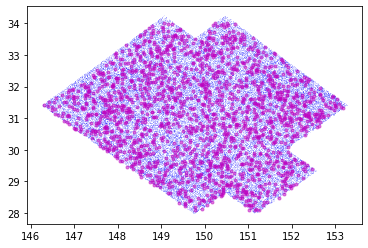

In [28]:
figure(figsize=(6,4))
plot(mtl['RA'], mtl['DEC'], 'b,', alpha=0.1)
plot(std['RA'], std['DEC'], 'm.', alpha=0.5)

Text(0.5, 0, 'STD density [deg$^{-2}$]')

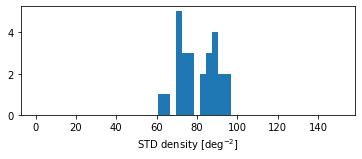

In [29]:
import collections
nstd = np.array(list(collections.Counter(std['HPXPIXEL']).values()))
figure(figsize=(6,2))
hist(nstd / hp.nside2pixarea(64, degrees=True), 50, (0,151))
xlabel('STD density [deg$^{-2}$]')

In [30]:
npix = len(set(std['HPXPIXEL']))
pixarea = hp.nside2pixarea(64, degrees=True)
len(std)/(npix*pixarea)

80.14981544666145

## Run target selection QA

In [31]:
targetfile = os.path.join(targetdir, 'targets-dark.fits')
targetQAdir = os.path.join(targetdir, 'qa')
targetQAlog = os.path.join(targetQAdir, 'target-qa.log')
os.makedirs(targetQAdir, exist_ok=True)

if not os.path.exists(targetQAdir+'/skymap-ALL.png'):
    cmd = 'run_target_qa {} {} --mocks --nside 16 --nosystematics'.format(targetfile, targetQAdir)
    with open(targetQAlog, 'w') as logfile:
        err = subprocess.call(cmd.split(), stdout=logfile, stderr=logfile)

    if err != 0:
        print('ERROR running {}'.format(cmd))
        msg = 'see {}'.format(targetQAlog)
        raise RuntimeError(msg)
else:
    print('Target QA already done; skipping')

Target QA already done; skipping


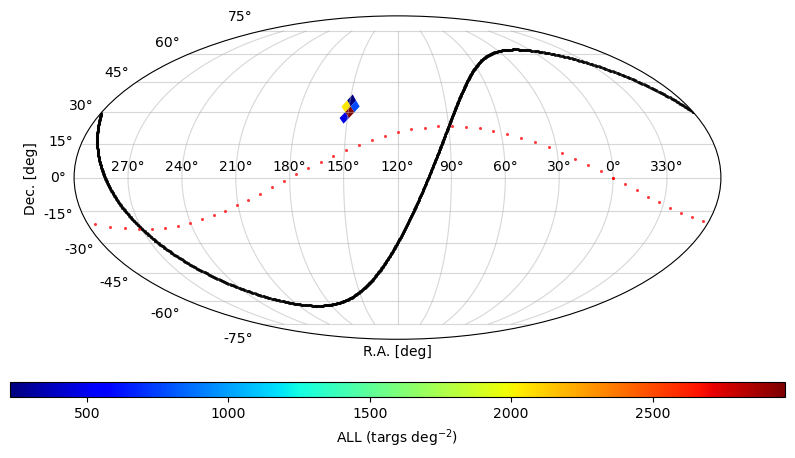

In [32]:
from IPython.display import Image, display, HTML
Image(targetQAdir+'/skymap-ALL.png', width=500)

In [33]:
def rowplot_images(imagefiles):
    x = ''.join( ["<img style='width: 300px; margin: 0px; float: left;' src='%s' />" % str(s) 
                 for s in imagefiles ])
    display(HTML(x))


targtypes = ['ELG', 'LRG', 'QSO']
qafiles = ['{}/histo-{}.png'.format(targetQAdir, tt) for tt in targtypes]
rowplot_images(qafiles)

targtypes = ['BGS_ANY', 'MWS_ANY']
qafiles = ['{}/histo-{}.png'.format(targetQAdir, tt) for tt in targtypes]
rowplot_images(qafiles)

## Run fiberassign

In [34]:
def is_fiberassign_done(fibassigndir, tiles, verbose=False):
    done = True
    for tileid in tiles['TILEID']:
        tilefile = os.path.join(fibassigndir, 'fiberassign-{:06d}.fits'.format(tileid))
        if not os.path.exists(tilefile):
            done = False
            if verbose:
                print('Missing {}'.format(tilefile))

    return done

is_fiberassign_done(fibassigndir, tiles)

True

In [35]:
if is_fiberassign_done(fibassigndir, tiles):
    print('fiberassign already done; skipping')
else:
    print('Generating lists of dark and bright tiles')
    #- Write list of tiles to consider
    dx = open(os.path.join(fibassigndir, 'dark-tiles.txt'), 'w')
    bx = open(os.path.join(fibassigndir, 'bright-tiles.txt'), 'w')
    for tileid, program  in zip(tiles['TILEID'], tiles['PROGRAM']):
        if program == 'BRIGHT':
            bx.write(str(tileid)+'\n')
        else:
            dx.write(str(tileid)+'\n')

    dx.close()
    bx.close()

    #- Remove any leftover tile files
    for tilefile in glob.glob(fibassigndir+'/tile_*.fits'):
        os.remove(tilefile)
        
    #- cp fiberstatus.ecsv example file into output area for archiving
    shutil.copy(minitestdir+'/fiberstatus.ecsv', fibassigndir+'/fiberstatus.ecsv')

    cmd = "fiberassign --overwrite"
    cmd += " --mtl {}/mtl-{{program}}.fits".format(targetdir)
    ## cmd += " --stdstar {}/{{stdfile}}".format(targetdir)
    cmd += " --sky {}/sky.fits".format(targetdir)
    cmd += " --surveytiles {}/{{tilefile}}".format(fibassigndir)
    ## cmd += " --fibstatusfile {}/fiberstatus.ecsv".format(fibassigndir)
    cmd += " --outdir {}/{{program}}".format(fibassigndir)

    #- Run fiberassign
    success = True
    for program in ['dark', 'bright']:
        logfilename = os.path.join(fibassigndir, 'fiberassign-{}.log'.format(program))
        print('logging to {}'.format(logfilename))
        with open(logfilename, 'a') as logfile:
            stdfile = 'standards-{}.fits'.format(program)
            tilefile = '{}-tiles.txt'.format(program)
            cmdx = cmd.format(stdfile=stdfile, tilefile=tilefile, program=program)
            print('RUNNING', cmdx)
            err = subprocess.call(cmdx.split(), stdout=logfile, stderr=logfile)
            if err != 0:
                success = False
                print('\nfiberassign failed err={}; see {}\n'.format(err, logfilename))
    
    #- Move the tile files into their final location
    for tileid, program  in zip(tiles['TILEID'], tiles['PROGRAM']):
        if program == 'GRAY':
            program = 'DARK'  #- dark and gray tiles are grouped together

        filename = '{}/{}/fiberassign-{:06d}.fits'.format(fibassigndir, program.lower(), tileid)
        shutil.move(filename, fibassigndir)

    if not success:
        raise RuntimeError('ERROR: fiberassign exited with non-zero error code')
        
    if is_fiberassign_done(fibassigndir, tiles, verbose=True):
        print('SUCCESS')
    else:
        raise RuntimeError('ERROR: missing fiberassign output files')
        

fiberassign already done; skipping


### Run fiberassign QA ###
This will find non-fatal errors with unassigned fibers and too few standards

**TODO**: are errors real, or problems with qa-fiberassign?

In [36]:
!qa-fiberassign --verbose --targets $targetdir/targets-dark.fits $fibassigndir/fiberassign-*.fits 

/global/cscratch1/sd/sjbailey/minitest-20.7/fiberassign/fiberassign-005346.fits - ERROR
    458 unassigned good fibers
    0 stuck, 0 broken, 557 sky, 100 stdstars
/global/cscratch1/sd/sjbailey/minitest-20.7/fiberassign/fiberassign-011108.fits - ERROR
    379 unassigned good fibers
    0 stuck, 0 broken, 528 sky, 100 stdstars
/global/cscratch1/sd/sjbailey/minitest-20.7/fiberassign/fiberassign-016870.fits - ERROR
    449 unassigned good fibers
    0 stuck, 0 broken, 539 sky, 100 stdstars
/global/cscratch1/sd/sjbailey/minitest-20.7/fiberassign/fiberassign-022632.fits - ERROR
    Petal 1 has 8/10 stdstars
    592 unassigned good fibers
    0 stuck, 0 broken, 730 sky, 98 stdstars
/global/cscratch1/sd/sjbailey/minitest-20.7/fiberassign/fiberassign-028394.fits - ERROR
    649 unassigned good fibers
    0 stuck, 0 broken, 790 sky, 100 stdstars
/global/cscratch1/sd/sjbailey/minitest-20.7/fiberassign/fiberassign-034156.fits - ERROR
    545 unassigned good fibers
    0 stuck, 0 broken, 702 sky, 

## Run newexp to combine surveysim, mocks, and fiberassign into simspec files

Setup the problem and define the commands to run, but then run them
in a separate window with desisim/newexp configured.

This step associates exposure IDs (EXPID) to observations and inserts 3 arcs and 3 flats
at the beginning of each night.

specsim is memory hungry so we are limited to one process per node, leaving
the other cores idle.

4.4 minutes for 12 arc, 12 flat, 18 science exposures on 15 nodes.

In [37]:
def is_newexp_done(explist, simdatadir, verbose=False):
    numnights = len(set(explist['NIGHT']))
    nexp = len(explist)  #- 3 arc/night + 3 flat/night + science
    simspecfiles = glob.glob(os.path.join(simdatadir, '*', '*', 'simspec*.fits'))
    fibermapfiles = glob.glob(os.path.join(simdatadir, '*', '*', 'fibermap*.fits'))
    if verbose:
        print('{}/{} simspec files'.format(len(simspecfiles), nexp))
        print('{}/{} fibermap files'.format(len(fibermapfiles), nexp))

    if len(simspecfiles) != nexp:
        return False
    elif len(fibermapfiles) != nexp:
        return False
    else:
        return True

# is_newexp_done(explist, simdatadir, verbose=True)

In [38]:
if is_newexp_done(explist, simdatadir):
    print('newexp already done; skipping')
else:
    logfilename = os.path.join(simdatadir, 'newexp.log')

    tilefile = os.path.join(surveydir, 'test-tiles.fits')
    assert os.path.exists(tilefile)

    nodes = 15
    cmd = "srun -A desi -N {nodes} -n {nodes} -c 64".format(nodes=nodes)
    cmd += " -C haswell -t 00:20:00 --qos interactive"
    cmd += " wrap-newexp --mpi --fiberassign {}".format(fibassigndir)
    cmd += " --mockdir {}".format(targetdir)
    cmd += " --obslist {}/exposures.fits".format(surveydir)
    cmd += " --tilefile {}".format(tilefile)

#     print("In a separate non-jupyter window, please run\n")
#     print(f"source {setupfile}")
#     print(f"{cmd}")
#     print("\nwhen that has finished, proceed with the notebook\n")
#     raise RuntimeError('This runtime error is to halt the notebook execution here; see instructions above')
    
    print('Running wrap-newexp batch job; should take ~5 min but could take more...')
    print('Starting at {}'.format(time.asctime()))
    print(cmd)
    print('Logging to {}'.format(logfilename))
    
    with open(logfilename, 'w') as logfile:
        err = subprocess.call(cmd.split(), stdout=logfile, stderr=logfile)
        if err != 0:
            print('\nERROR {} running wrap-newexp; see {}'.format(err, logfilename))
        else:
            print('done')


newexp already done; skipping


### Confirm that we got the expected newexp output files

In [39]:
if is_newexp_done(explist, simdatadir, verbose=True):
    print('Success')
else:
    print('ERROR: Missing files')
    raise RuntimeError

57/57 simspec files
57/57 fibermap files
Success


## Run fastframe to generate noisy uncalibrated spectra

fastframe is a stripped down version of quickgen, and it uses specsim under the hood.
specsim is memory hungry so we are limited to one process per node, leaving
the other cores idle.

6.3 minutes for 12 arc, 12 flat, 18 science exposures on 15 nodes

In [40]:
def is_fastframe_done(explist, reduxdir, verbose=False):
    nflat = np.count_nonzero(explist['FLAVOR'] == 'flat')
    nscience = np.count_nonzero(explist['FLAVOR'] == 'science')
    nframe = 30*(nflat + nscience)
    framefiles = glob.glob(reduxdir+'/exposures/*/*/frame*.fits')
    if verbose:
        print('{}/{} frame files'.format(len(framefiles), nframe))
    
    if len(framefiles) != nframe:
        return False
    else:
        return True

is_fastframe_done(explist, reduxdir, verbose=True)

1170/1170 frame files


True

In [41]:
if is_fastframe_done(explist, reduxdir, verbose=True):
    print('fastframe already done; skipping')
else:
    logfilename = os.path.join(reduxdir, 'exposures', 'fastframe.log')
    os.makedirs(os.path.dirname(logfilename), exist_ok=True)
    print('Running fastframe batch job')
    print('Starting at {}'.format(time.asctime()))
    print('Logging to {}'.format(logfilename))
    nodes = 15

    cmd = "srun -A desi -N {nodes} -n {nodes} -c 64 -C haswell -t 00:45:00 --qos interactive".format(nodes=nodes)
    cmd += " wrap-fastframe --mpi"
    
#     print("In a separate non-jupyter window, please run\n")
#     print(f"source {setupfile}")
#     print(f"{cmd}")
#     print("\nwhen that has finished, proceed with the notebook\n")
#     raise RuntimeError('This runtime error is to halt the notebook execution here; see instructions above')

    with open(logfilename, 'w') as logfile:
        err = subprocess.call(cmd.split(), stdout=logfile, stderr=logfile)
        if err != 0:
            print('ERROR {} running wrap-fastframe; see {}'.format(err, logfilename))
        else:
            print('done at {}'.format(time.asctime()))

if is_fastframe_done(explist, reduxdir, verbose=True):
    print('SUCCESS')
else:
    print('ERROR; see {}'.format(logfilename))
    raise RuntimeError

1170/1170 frame files
fastframe already done; skipping
1170/1170 frame files
SUCCESS


In [42]:
is_fastframe_done(explist, reduxdir, verbose=True)

1170/1170 frame files


True

In [43]:
#- Check individual framefile outputs
ntot = 0
nbad = 0
for night, expid, flavor in explist['NIGHT', 'EXPID', 'FLAVOR']:
    if flavor != 'flat' and flavor != 'science':
        continue

    for channel in ['b', 'r', 'z']:
        for spectrograph in range(10):
            camera = channel + str(spectrograph)
            framefile = desispec.io.findfile('frame', night, expid, camera)
            ntot += 1
            if not os.path.exists(framefile):
                nbad += 1
                print('Missing {} frame {}'.format(flavor, framefile))

if nbad > 0:
    print('Missing {}/{} frame files'.format(nbad, ntot))
else:
    print('All {} science and flat frame files generated'.format(ntot))

All 1170 science and flat frame files generated


## Run the spectro pipeline

### First, create the production database.

In [44]:
pipe_setup_file = desispec.io.specprod_root() + '/setup.sh'

if not os.path.exists(pipe_setup_file):
    print('creating production database and setup script')
    cmd = "desi_pipe create --db-postgres --force"
    cmd += " --data {}".format(os.getenv('DESI_SPECTRO_DATA'))
    cmd += " --redux {}".format(os.getenv('DESI_SPECTRO_REDUX'))
    cmd += " --prod {}".format(os.getenv('SPECPROD'))
    print(cmd)
    err = subprocess.call(cmd.split())
    assert err == 0
    # assert os.path.exists(desispec.io.get_pipe_database())
    print('SUCCESS')
else:
    print(pipe_setup_file)
    print('spectro pipeline setup file already exists; skipping')


/global/cscratch1/sd/sjbailey/minitest-20.7/spectro/redux/mini/setup.sh
spectro pipeline setup file already exists; skipping


### Read the pipeline setup.sh file to get the postgres DB location
From the command line we would just source this file, but here we need the jupyter
notebook to have that environment, thus the parsing.  `$DESI_SPECTRO_REDUX` and `$SPECPROD`
are evaluated within the setup.sh file itself, so handle those separately

In [45]:
os.environ['DESI_SPECTRO_REDUX'] = os.path.dirname(reduxdir)
os.environ['SPECPROD'] = os.path.basename(reduxdir)

In [46]:

with open(pipe_setup_file) as fx:
    for line in fx:
        line = line.strip()
        if line.startswith('export '):
            keyvalue = line.split(' ')[1]
            key, value = keyvalue.split('=', maxsplit=1)
            if key in ('DESI_SPECTRO_REDUX', 'SPECPROD'):
                continue
            if key in os.environ and value != os.environ[key]:
                print('{} {} -> {}'.format(key, os.environ[key], value))
            elif key not in os.environ:
                print('Setting {}={}'.format(key, value))
            
            os.environ[key] = value

Setting DESI_SPECTRO_DB=postgresql:nerscdb03.nersc.gov:5432:desidev:desidev_admin:pipe_3c793b6e6756e381aa23cc9bd0f73732


### Sync up with the actual files on disk

We didn't start with raw data files, so we'll skip over extraction and PSF-fitting steps.
`desi_pipe sync` will update the database from what files are actually on disk.

In [47]:
err        = subprocess.call('desi_pipe sync'.split())
assert err == 0
output     = subprocess.check_output('desi_pipe top --once'.split())
print(output.decode())

----------------+---------+---------+---------+---------+---------+---------+
   Task Type    | waiting | ready   | running | done    | failed  | submit  |
----------------+---------+---------+---------+---------+---------+---------+
preproc         |     1710|        0|        0|        0|        0|        0|
psf             |      540|        0|        0|        0|        0|        0|
psfnight        |      180|        0|        0|        0|        0|        0|
traceshift      |     1170|        0|        0|        0|        0|        0|
extract         |        0|        0|        0|     1170|        0|        0|
fiberflat       |        0|        0|        0|      540|        0|        0|
fiberflatnight  |        0|        0|        0|      180|        0|        0|
sky             |        0|        0|        0|      630|        0|        0|
starfit         |        0|        0|        0|      210|        0|        0|
fluxcalib       |        0|        0|        0|      630|       

### Run pipeline scripts as a series of interactive jobs

`desi_pipe chain` would be a more convenient way of doing this,
but for the minitest it takes too long to wait for N>>1 jobs in the debug queue,
so we'll wrap this with interactive queue batch jobs.

In [48]:
taskdir = os.path.join(desispec.io.get_pipe_rundir(), 'minitest')
os.makedirs(taskdir, exist_ok=True)

dbpath = desispec.io.get_pipe_database()
db = desispec.pipeline.load_db(dbpath, mode="w")

tasktypes = ['fiberflat', 'fiberflatnight', 'sky', 'starfit', 'fluxcalib', 'cframe', 'spectra', 'redshift']
for tasktype in tasktypes:
    for night in np.unique(explist['NIGHT']):
        db.getready(night)

    taskfile = "{}/{}.tasks".format(taskdir, tasktype)
    cmd = "desi_pipe tasks --tasktype {} --states ready,waiting ".format(tasktype)
    cmd += " > {}".format(taskfile)
    try:
        subprocess.check_call(cmd, shell=True)
    except subprocess.CalledProcessError:
        print('FAILED: {}'.format(cmd))
        break
    
    task_count = db.count_task_states(tasktype)
    if tasktype == 'redshift':
        ranks_per_task = 32
        cores_per_rank = 2
        n = task_count['ready'] * ranks_per_task // 2  #- two iterations
        nodes = (n-1) // 32 + 1
        runtime = 59    #- minutes
    elif tasktype == 'spectra':
        ranks_per_task = 1
        cores_per_rank = 16
        n = task_count['ready'] * ranks_per_task
        runtime = 30    #- minutes
    elif tasktype == 'cframe':
        ranks_per_task = 1
        cores_per_rank = 2
        n = task_count['ready'] * ranks_per_task
        runtime = 10     #- minutes

    else:
        ranks_per_task = 1
        cores_per_rank = 2
        n = task_count['ready'] * ranks_per_task
        runtime = 20    #- minutes

    nodes = (n*cores_per_rank-1) // 64 + 1

    if n > 0:
        t0 = time.time()
        cmd = 'srun -A desi -t {}:00 -C haswell --qos interactive'.format(runtime)
        cmd += ' -N {nodes} -n {procs} -c {cores} '.format(nodes=nodes, procs=n, cores=cores_per_rank)
        cmd += ' desi_pipe_exec_mpi --tasktype {} --taskfile {}'.format(tasktype, taskfile)
        logfilename = '{}/{}.log'.format(taskdir, tasktype)
        print('Running {} {} tasks'.format(task_count['ready'], tasktype))
        print('Logging to {}'.format(logfilename))
        print(cmd)
        
        with open(logfilename, 'w', buffering=1) as logfile:
            err = subprocess.call(cmd.split(), stdout=logfile, stderr=logfile)
            if err != 0:
                print('    ERROR {} for tasktype {}'.format(err, tasktype))
                print('    See {}'.format(logfilename))
            else:
                dt = time.time() - t0
                print('  DONE at {}'.format(time.asctime()))
                print('  {} took {:.1f} min'.format(tasktype, dt/60))
    elif task_count['waiting'] == 0 and task_count['done'] > 0:
        print('All {} tasks already run'.format(tasktype))
    else:
        print('No {} tasks ready to run; skipping'.format(tasktype))

for night in np.unique(explist['NIGHT']):
    db.getready(night)

print(subprocess.check_output('desi_pipe top --once'.split()).decode())

All fiberflat tasks already run
All fiberflatnight tasks already run
All sky tasks already run
All starfit tasks already run
All fluxcalib tasks already run
All cframe tasks already run
Running 26 spectra tasks
Logging to /global/cscratch1/sd/sjbailey/minitest-20.7/spectro/redux/mini/run/minitest/spectra.log
srun -A desi -t 30:00 -C haswell --qos interactive -N 7 -n 26 -c 16  desi_pipe_exec_mpi --tasktype spectra --taskfile /global/cscratch1/sd/sjbailey/minitest-20.7/spectro/redux/mini/run/minitest/spectra.tasks
  DONE at Tue Aug  4 22:20:19 2020
  spectra took 3.7 min
Running 26 redshift tasks
Logging to /global/cscratch1/sd/sjbailey/minitest-20.7/spectro/redux/mini/run/minitest/redshift.log
srun -A desi -t 59:00 -C haswell --qos interactive -N 13 -n 416 -c 2  desi_pipe_exec_mpi --tasktype redshift --taskfile /global/cscratch1/sd/sjbailey/minitest-20.7/spectro/redux/mini/run/minitest/redshift.tasks
  DONE at Tue Aug  4 22:47:10 2020
  redshift took 26.6 min
----------------+---------+

### Check that we got expected outputs

In [49]:
def is_cframe_done(explist, reduxdir, verbose=False):
    nscience = np.count_nonzero(explist['FLAVOR'] == 'science')
    ncframe = 30*nscience
    cframefiles = glob.glob(reduxdir+'/exposures/*/*/cframe*.fits')
    if verbose:
        print('{}/{} cframe files'.format(len(cframefiles), ncframe))
    
    if len(cframefiles) != ncframe:
        return False
    else:
        return True

is_cframe_done(explist, reduxdir, verbose=True)

630/630 cframe files


True

In [50]:
if is_cframe_done(explist, reduxdir, verbose=True):
    print('All cframe files successfully generated')
else:
    print('ERROR: missing cframe files')
    raise RuntimeError

630/630 cframe files
All cframe files successfully generated


In [51]:
def is_regrouping_done(pixels, reduxdir):
    specfiles = glob.glob(reduxdir+'/spectra-*/*/*/spectra-*.fits')
    #- some pixels might not be covered by real data, but most should be
    if len(specfiles) < len(pixels) - 5:
        return False
    else:
        return True

is_regrouping_done(pixels, reduxdir)

True

## Did all pixels make it from sims -> output spectra?

tiles2pix may have been conservative and included some edge pixels that weren't
really necessary.

All spectra files generated


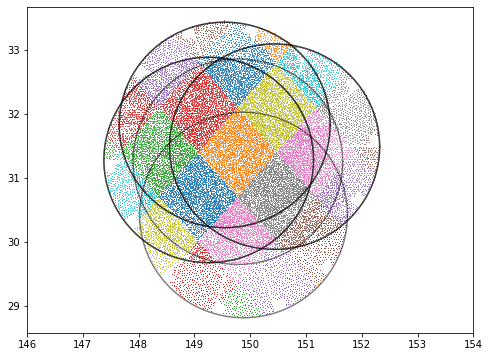

In [52]:
nside=64
misspix = list()
figure(figsize=(8,6))

for p in pixels:
    specfile = desispec.io.findfile('spectra', nside=nside, groupname=str(p))

    if not os.path.exists(specfile):
        print('Missing {}'.format(os.path.basename(specfile)))
        misspix.append(p)
    
    else:
        fibermap = Table.read(specfile, 'FIBERMAP')
        plot(fibermap['TARGET_RA'], fibermap['TARGET_DEC'], ',', alpha=0.5)

plot_healpix(nside, misspix)

for t in tiles:
    plot_tile(t['RA'], t['DEC'])

tmp = xlim(146, 154)

if len(misspix) > 0:
    raise RuntimeError('missing healpix')
else:
    print("All spectra files generated")

In [53]:
def is_redrock_done(reduxdir, verbose=False):
    specfiles = glob.glob(reduxdir+'/spectra-*/*/*/spectra*.fits')
    zbestfiles = glob.glob(reduxdir+'/spectra-*/*/*/zbest*.fits')
    if verbose:
        print('{}/{} zbest files'.format(len(zbestfiles), len(specfiles)))
    if len(zbestfiles) != len(specfiles):
        return False
    else:
        return True

if not is_redrock_done(reduxdir, verbose=True):
    raise RuntimeError("Missing redrock files")

26/26 zbest files


### Count number of spectra and targets per healpix

In [54]:
specdir   = os.path.join(os.environ['DESI_SPECTRO_REDUX'], os.environ['SPECPROD'], 'spectra-64')
specfiles = list()

for specfile in sorted(list(desitarget.io.iter_files(specdir, 'spectra'))):
    fm = desispec.io.read_fibermap(specfile)
    ntarg = len(np.unique(fm['TARGETID']))
    nspec = len(fm) * 3
    specfiles.append( (ntarg, nspec, os.path.basename(specfile)) )

In [55]:
print('==================== ===== ========')
print('specfile             nspec ntargets')
print('==================== ===== ========')

for ntarg, nspec, specfile in sorted(specfiles):
    print("{0:20s} {1:5d} {2:8d}".format(os.path.basename(specfile), nspec, ntarg))

print('==================== ===== ========')

==================== ===== ========
specfile             nspec ntargets
==================== ===== ========
spectra-64-5262.fits    72        4
spectra-64-5263.fits    90        5
spectra-64-5633.fits   426       69
spectra-64-5281.fits  2394      133
spectra-64-5297.fits  1002      164
spectra-64-5307.fits  2172      278
spectra-64-5648.fits  2433      306
spectra-64-5284.fits  9096      530
spectra-64-5283.fits  8598      560
spectra-64-5291.fits  5568      764
spectra-64-5299.fits  5442      864
spectra-64-5296.fits  7176      867
spectra-64-5636.fits  6555      919
spectra-64-5305.fits  7485     1086
spectra-64-5285.fits 13056     1100
spectra-64-5637.fits  8334     1128
spectra-64-5289.fits 12201     1144
spectra-64-5286.fits 20871     2250
spectra-64-5306.fits 17142     2355
spectra-64-5298.fits 22593     2692
spectra-64-5294.fits 22863     2779
spectra-64-5295.fits 23856     3152
spectra-64-5304.fits 24681     3167
spectra-64-5292.fits 30042     3286
spectra-64-5287.fits 30096  

## Create zcatalog

This is just a merging of the individual zbest files and cross matching to the target table

In [56]:
zcatfile = desispec.io.findfile('zcatalog')
cmd = 'desi_zcatalog -i {reduxdir}/spectra-64 -o {zcatfile} --match {targetdir}/targets-dark.fits'.format(
    reduxdir=reduxdir, zcatfile=zcatfile, targetdir=targetdir)

if os.path.exists(zcatfile):
    print(f"zcatalog already exists, skipping command:\n{cmd}")
else:
    print(cmd)
    !$cmd

desi_zcatalog -i /global/cscratch1/sd/sjbailey/minitest-20.7/spectro/redux/mini/spectra-64 -o /global/cscratch1/sd/sjbailey/minitest-20.7/spectro/redux/mini/zcatalog-mini.fits --match /global/cscratch1/sd/sjbailey/minitest-20.7/targets/targets-dark.fits
INFO:desi_zcatalog:169:<module>: matching /global/cscratch1/sd/sjbailey/minitest-20.7/targets/targets-dark.fits
INFO:desi_zcatalog:175:<module>: wrote /global/cscratch1/sd/sjbailey/minitest-20.7/spectro/redux/mini/zcatalog-mini.fits


## Redshift QA

This section does some "by-hand" redshift QA, bypassing the standard spectro pipeline QA (see below).

In [57]:
from desisim.spec_qa import redshifts as dsq_z
import astropy.table
import numpy as np
from matplotlib.pyplot import hist
from astropy.table import Table

In [58]:
truth = Table.read(os.path.join(targetdir, 'truth-dark.fits'), 'TRUTH')
zcat = Table.read(zcatfile)

truth['TRUESPECTYPE'] = np.char.strip(truth['TRUESPECTYPE'])
truth['TEMPLATETYPE'] = np.char.strip(truth['TEMPLATETYPE'])
zcat['SPECTYPE'] = np.char.strip(zcat['SPECTYPE'])

#- Add OIIFLUX by hand only for ELGs
truth_elg = Table.read(os.path.join(targetdir, 'truth-dark.fits'), 'TRUTH_ELG')
del truth_elg.meta['EXTNAME']
truth = astropy.table.join(truth, truth_elg, join_type='left')

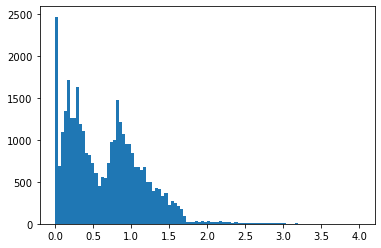

In [59]:
_ = hist(zcat['Z'], 100, (0, 4))

In [60]:
del zcat.meta['EXTNAME']
del truth.meta['EXTNAME']

ztruth = astropy.table.join(zcat, truth, keys='TARGETID')

In [61]:
isELG = (ztruth['TEMPLATETYPE'] == 'ELG')
isQSO = (ztruth['TEMPLATETYPE'] == 'QSO')
isLRG = (ztruth['TEMPLATETYPE'] == 'LRG')
isSTAR = (ztruth['TEMPLATETYPE'] == 'STAR')
isBGS = (ztruth['TEMPLATETYPE'] == 'BGS')

print('QSO ', np.count_nonzero(isQSO))
print('LRG ', np.count_nonzero(isLRG))
print('ELG ', np.count_nonzero(isELG))
print('STAR', np.count_nonzero(isSTAR))
print('BGS ', np.count_nonzero(isBGS))

QSO  1168
LRG  2404
ELG  10299
STAR 1219
BGS  5214


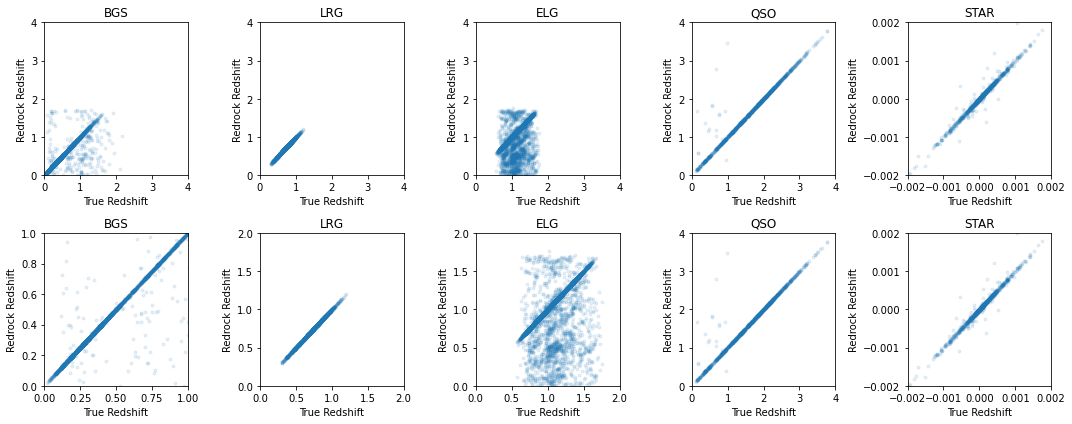

In [62]:
from matplotlib.pyplot import figure, subplot, plot, title, xlim, ylim, xlabel, ylabel, tight_layout

def plotz(ztruth, label, zmin=0.0, zmax=1.5):
    plot(ztruth['TRUEZ'], ztruth['Z'], '.', label=label, alpha=0.1)
    title(label)
    xlim(zmin, zmax); ylim(zmin, zmax)
    xlabel('True Redshift')
    ylabel('Redrock Redshift')

figure(figsize=(15,6))

subplot(251); plotz(ztruth[isBGS], 'BGS', zmax=4)
subplot(252); plotz(ztruth[isLRG], 'LRG', zmax=4)
subplot(253); plotz(ztruth[isELG], 'ELG', zmax=4)
subplot(254); plotz(ztruth[isQSO], 'QSO', zmax=4)
subplot(255); plotz(ztruth[isSTAR], 'STAR', zmin=-0.002, zmax=0.002)

subplot(256); plotz(ztruth[isBGS], 'BGS', zmax=1)
subplot(257); plotz(ztruth[isLRG], 'LRG', zmax=2)
subplot(258); plotz(ztruth[isELG], 'ELG', zmax=2)
subplot(259); plotz(ztruth[isQSO], 'QSO', zmax=4)
subplot(2,5,10); plotz(ztruth[isSTAR], 'STAR', zmin=-0.002, zmax=0.002)

tight_layout()

In [63]:
# Merge the truth and zcat tables
# match_truth_z fails on the repeated TARGETID=-1 of unassigned fibers, so filter those out
assigned = zcat['TARGETID'] >= 0
dsq_z.match_truth_z(truth, zcat[assigned], mini_read=True)

In [64]:
print('          ntarg   good  fail  miss  lost')
for objtype in set(truth['TEMPLATETYPE']):
    #isx = (truth['TEMPLATETYPE'] == objtype)
    pgood, pfail, pmiss, plost, nx = dsq_z.zstats(truth, objtype=objtype)
    #nx = np.count_nonzero(isx)
    print('{:6s} {:8d}  {:5.1f} {:5.1f} {:5.1f} {:5.1f}'.format(objtype, nx, pgood, pfail, pmiss, plost))

print()
print('good = correct redshift and ZWARN==0')
print('fail = bad redshift and ZWARN==0 (i.e. catastrophic failures)')
print('miss = correct redshift ZWARN!=0 (missed opportunities)')
print('lost = wrong redshift ZWARN!=0 (wrong but at least we know it)')

          ntarg   good  fail  miss  lost
QSO        1168   97.3   0.5   1.1   1.1
WD           39   97.4   0.0   2.6   0.0
LRG        2493   99.8   0.0   0.2   0.0
ELG       11372   72.3   1.0  10.1  16.6
BGS        3961   94.4   0.1   3.4   2.2
STAR       1219   86.8   0.7   2.3  10.3

good = correct redshift and ZWARN==0
fail = bad redshift and ZWARN==0 (i.e. catastrophic failures)
miss = correct redshift ZWARN!=0 (missed opportunities)
lost = wrong redshift ZWARN!=0 (wrong but at least we know it)


## Specriteriaal Classification Confusion Matrix

To be replaced with `desisim.spec_qa.redshifts.spectype_confusion` in a post-18.3 version.

In [65]:
#- Confusion matrix
specmix = dict()
spectypes = sorted(set(ztruth['TRUESPECTYPE']))

for s1 in spectypes:
    specmix[s1] = dict()
    for s2 in spectypes:
        n = np.count_nonzero((ztruth['TRUESPECTYPE']==s1) & (ztruth['SPECTYPE'] == s2))
        specmix[s1][s2] = n

In [66]:
#- Print header line
print('            Redrock')
print('Truth     ', end='')
for s1 in spectypes:
    print('{:>8s}'.format(s1), end='')
print()
    
for s1 in spectypes:
    print('{:8s}  '.format(s1), end='')
    for s2 in spectypes:
        print('{:8d}'.format(specmix[s1][s2]), end='')
    print()

            Redrock
Truth       GALAXY     QSO    STAR      WD
GALAXY       17908       9       0       0
QSO             10    1158       0       0
STAR           162       0    1057       0
WD               0       0      39       0


## Study target coverage

<ipython-input-67-a0913f5e8549>:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  subplot(6,2,11); xlabel('NUMTILE')
<ipython-input-67-a0913f5e8549>:22: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  subplot(6,2,12); xlabel('NUMEXP')


Text(0.5, 0, 'NUMEXP')

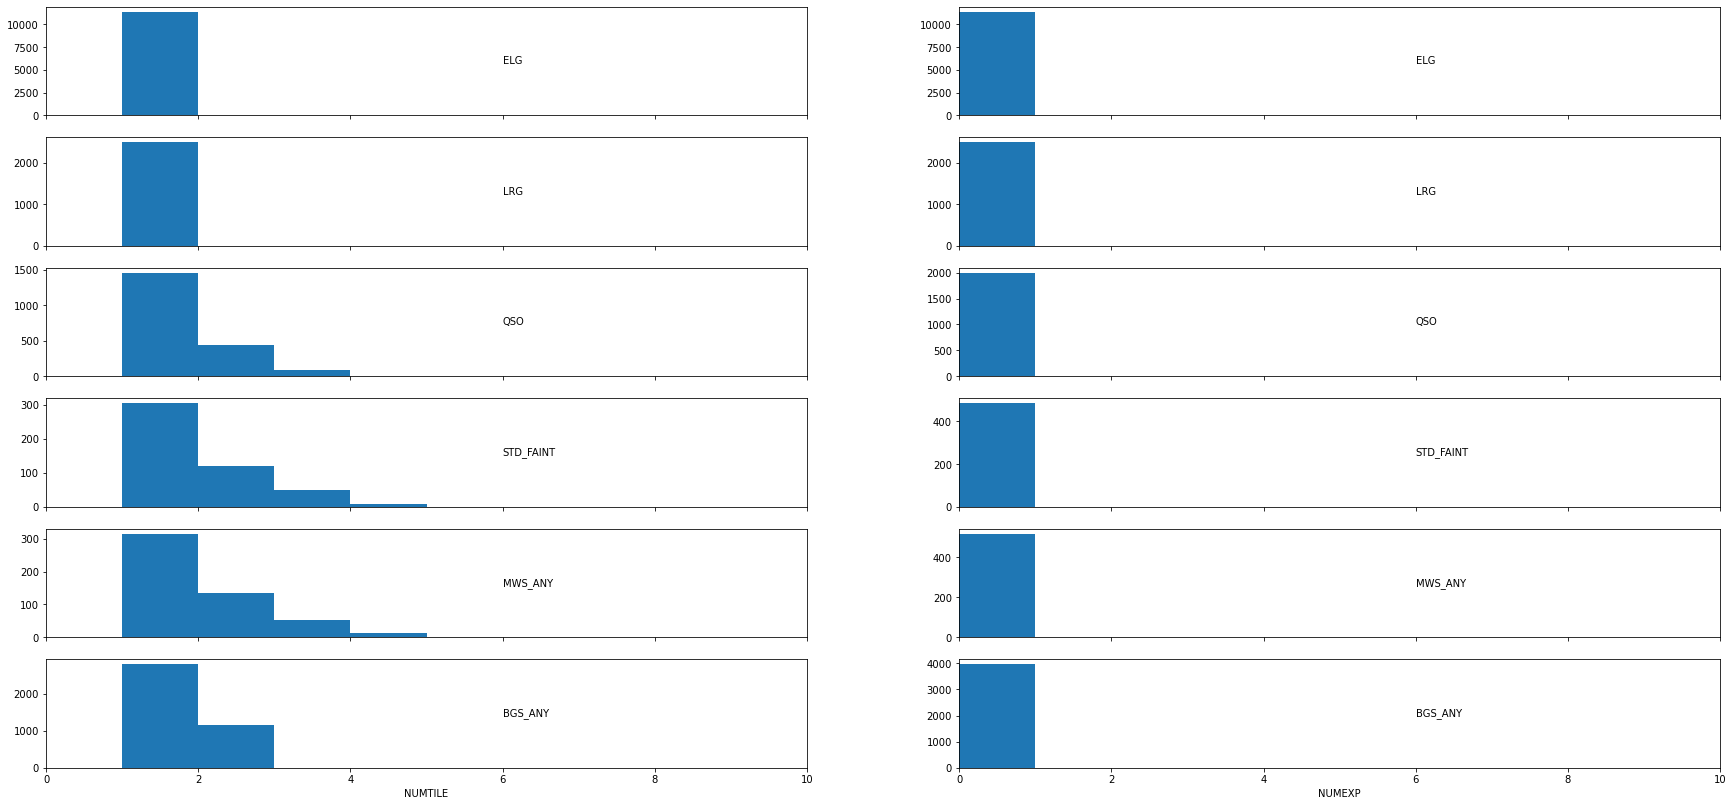

In [67]:
from desitarget.targetmask import desi_mask
from collections import Counter

figure(figsize=(30,14))

for i, targtype in enumerate(['ELG', 'LRG', 'QSO', 'STD_FAINT', 'MWS_ANY', 'BGS_ANY']):
    ii = (zcat['DESI_TARGET'] & desi_mask[targtype]) != 0
    subplot(6,2,1+2*i)
    n = hist(zcat['NUMTILE'][ii], 10, (0,10))[0]
    text(6, np.max(n)/2, targtype)
    xlim(0,10)
    if i<5:
        xticks([0,2,4,6,8,10], ['']*6)
    subplot(6,2,2+2*i)
    n = hist(zcat['NUMEXP'][ii], 10, (0,10))[0]
    text(6, np.max(n)/2, targtype)
    xlim(0,10)
    if i<5:
        xticks([0,2,4,6,8,10], ['']*6)

subplot(6,2,11); xlabel('NUMTILE')
subplot(6,2,12); xlabel('NUMEXP')

## Load the Spectro Catalog Database

Start by configuring the database, then load exposures, truth, targets, fiberassign, and the redshift catalog.

In [68]:
import importlib
import desispec.database.redshift

importlib.reload(desispec.database.redshift)

<module 'desispec.database.redshift' from '/global/common/software/desi/cori/desiconda/20200801-1.4.0-spec/code/desispec/0.34.6/lib/python3.8/site-packages/desispec-0.34.6-py3.8.egg/desispec/database/redshift.py'>

In [69]:
import os

from argparse                   import Namespace

from desispec.database.redshift import (setup_db, dbSession, load_file, ObsList, Target, Truth, ZCat, FiberAssign,
                                        load_fiberassign, update_truth)

options      = Namespace(overwrite=True, dbfile=os.path.join(basedir, 'minitest.db'), hostname=None, maxrows=2000,
                         chunksize=50000, schema=None, username=None, verbose=False, datapath=basedir)

# We'll be using a SQLite database, ignore the return value of setup_db.
postgresql = setup_db(options)

print(expfile)

print('--- Loading exposure list')
load_file(expfile, ObsList, hdu='EXPOSURES', expand={'PASS': 'passnum'})

print('--- Loading truth tables')
load_file(os.path.join(targetdir, 'truth-dark.fits'), Truth, hdu='TRUTH')

for h in ('BGS', 'ELG', 'LRG', 'QSO', 'STAR', 'WD'):
    update_truth(os.path.join(targetdir, 'truth-dark.fits'), 'TRUTH_' + h)

print('--- Loading targets')

load_file(os.path.join(targetdir, 'targets-dark.fits'), Target, hdu='TARGETS',
          expand={'DCHISQ': ('dchisq_psf', 'dchisq_rex', 'dchisq_dev', 'dchisq_exp', 'dchisq_comp',)})

print('--- loading redshift catalog')
load_file(os.path.join(reduxdir, 'zcatalog-mini.fits'), ZCat, hdu='ZCATALOG',
          expand={'COEFF': ('coeff_0', 'coeff_1', 'coeff_2', 'coeff_3', 'coeff_4',
                            'coeff_5', 'coeff_6', 'coeff_7', 'coeff_8', 'coeff_9',)},
          rowfilter=lambda x: ((x['TARGETID'] != 0) & (x['TARGETID'] != -1)))

print('--- loading fiber assignments')
load_fiberassign(fibassigndir)

print('--- done')

INFO:redshift.py:830:setup_db: Begin creating tables.
INFO:redshift.py:834:setup_db: Finished creating tables.
/global/cscratch1/sd/sjbailey/minitest-20.7/survey/exposures.fits
--- Loading exposure list
INFO:redshift.py:383:load_file: Read data from /global/cscratch1/sd/sjbailey/minitest-20.7/survey/exposures.fits HDU EXPOSURES
INFO:redshift.py:401:load_file: Integrity check complete on obslist.
INFO:redshift.py:409:load_file: Initial column conversion complete on obslist.
INFO:redshift.py:431:load_file: Column expansion complete on obslist.
INFO:redshift.py:437:load_file: Column conversion complete on obslist.
INFO:redshift.py:444:load_file: Converted columns into rows on obslist.
INFO:redshift.py:450:load_file: Inserted 57 rows in obslist.
--- Loading truth tables
INFO:redshift.py:383:load_file: Read data from /global/cscratch1/sd/sjbailey/minitest-20.7/targets/truth-dark.fits HDU TRUTH
INFO:redshift.py:401:load_file: Integrity check complete on truth.
INFO:redshift.py:409:load_file:

### Demonstrate the SQLAlchemy objects

In [70]:
tt = dbSession.query(Truth, Target).filter(Truth.targetid == Target.targetid).all()

In [71]:
zz = dbSession.query(Truth, ZCat).filter(Truth.targetid == ZCat.targetid).all()

In [72]:
ff = dbSession.query(Truth, FiberAssign).filter(Truth.targetid == FiberAssign.targetid).all()

In [73]:
# How many actual exposures are there with the Moon up?
q = dbSession.query(ObsList.expid, ObsList.moonsep, ObsList.moonalt, ObsList.moonfrac).filter(ObsList.moonalt > 0).all()
q

[(12, 123.13546141348719, 0.36553269398120836, 0.4860868273443142),
 (13, 123.22148646221466, 2.214216784255613, 0.4853390623651027),
 (20, 148.52114200273243, 0.3807958592569187, 0.2822299851429323),
 (21, 148.59087270633106, 2.085583694358448, 0.28165345972167305),
 (28, 117.69487880839623, 2.435871219205042, 0.03408127361103964),
 (29, 117.61237867333327, 0.29558182660100596, 0.034385542777193474),
 (36, 106.12964017968311, 12.331712249031415, 0.07608065652236175),
 (37, 106.00451898403153, 8.890716538808793, 0.07675219704898228),
 (44, 81.8633129334977, 34.47257215957274, 0.20541479433998364),
 (45, 81.7854571119222, 31.964181388967415, 0.20612650859342038),
 (46, 82.15999866978933, 29.97359499176731, 0.2066919801929061),
 (47, 82.08173557640028, 27.541033291237895, 0.20738419542573433),
 (54, 118.50990621052495, 0.4008981593444536, 0.7545447815726879),
 (55, 118.58070118588797, 1.8382814474903904, 0.7540001078638929),
 (56, 118.64482439983828, 3.1436182624949884, 0.753500823631365

In [74]:
expid_up = [x[0] for x in q]
expid_up

[12, 13, 20, 21, 28, 29, 36, 37, 44, 45, 46, 47, 54, 55, 56]

In [75]:
q = dbSession.query(ZCat.targetid, Target.desi_target, Target.bgs_target, Target.mws_target, ObsList.expid)\
             .filter(ZCat.targetid      == FiberAssign.targetid)\
             .filter(ZCat.targetid      == Target.targetid)\
             .filter(FiberAssign.tileid == ObsList.tileid)\
             .filter(ObsList.expid.in_(expid_up))\
             .order_by(ZCat.targetid, ObsList.expid).all()

targetid, desi_target, bgs_target, mws_target, expid = zip(*q)

In [76]:
from desitarget.targetmask import (desi_mask, mws_mask, bgs_mask)

sum(['ELG' in desi_mask.names(t) for t in desi_target])

34788

In [77]:
#
# OK, let's find some ELGs with the Moon up, and some with the Moon down.
#
q_up = dbSession.query(ZCat.targetid, Truth.truez, ZCat.z, ZCat.zwarn,
                      ((ZCat.z - Truth.truez)/(1.0 + Truth.truez)).label('dz'))\
                   .filter(Truth.targetid == ZCat.targetid)\
                   .filter(Target.targetid == ZCat.targetid)\
                   .filter(ZCat.targetid == FiberAssign.targetid)\
                   .filter(FiberAssign.tileid == ObsList.tileid)\
                   .filter(ObsList.expid.in_(expid_up))\
                   .filter(Target.desi_target.op('&')(desi_mask.ELG) != 0)\
                   .all()

q_dn = dbSession.query(ZCat.targetid, Truth.truez, ZCat.z, ZCat.zwarn,
                       ((ZCat.z - Truth.truez)/(1.0 + Truth.truez)).label('dz'))\
                   .filter(Truth.targetid == ZCat.targetid)\
                   .filter(Target.targetid == ZCat.targetid)\
                   .filter(ZCat.targetid == FiberAssign.targetid)\
                   .filter(FiberAssign.tileid == ObsList.tileid)\
                   .filter(~ObsList.expid.in_(expid_up))\
                   .filter(Target.desi_target.op('&')(desi_mask.ELG) != 0)\
                   .all()[:8342]

foo, truez_up, z_up, zwarn_up, dz_up = zip(*q_up)
foo, truez_dn, z_dn, zwarn_dn, dz_dn = zip(*q_dn)

truez_up = np.array(truez_up)
z_up     = np.array(z_up)
zwarn_up = np.array(zwarn_up)

## dv_up    = lightspeed.to('km / s').value * np.array(dz_up)

truez_dn = np.array(truez_dn)
z_dn     = np.array(z_dn)
zwarn_dn = np.array(zwarn_dn)

##  dv_dn    = lightspeed.to('km / s').value * np.array(dz_dn)
ok_up    = zwarn_up == 0
ok_dn    = zwarn_dn == 0

ValueError: not enough values to unpack (expected 5, got 0)

In [ ]:
import matplotlib.pyplot as plt


# Observed redshift versus true redshift.
fig, axes = plt.subplots(1, 1, figsize=(8, 8), dpi=100)

p1  = axes.plot(truez_up[ok_up], z_up[ok_up], 'r.', label='Moon Up')
p2  = axes.plot(truez_dn[ok_dn], z_dn[ok_dn], 'b.', label='Moon Down')

foo = axes.set_xlabel('True redshift')
foo = axes.set_ylabel('Pipeline redshift')

foo = axes.legend(loc=4)

In [ ]:
# Print the table columns and their types.
[(c.name, c.type) for c in ZCat.__table__.columns]

In [ ]:
type(tt[0][0])

In [ ]:
dir(tt[0][0])

In [ ]:
tt[0][0]

In [ ]:
type(tt[0][1])

In [ ]:
dir(tt[0][1])

In [ ]:
type(zz[0][0])

In [ ]:
dir(zz[0][0])

In [ ]:
type(zz[0][1])

In [ ]:
dir(zz[0][1])

In [ ]:
import numpy as np

np.unique(zz[0][1].zwarn, return_counts=True)

In [ ]:
type(ff[0][0])

In [ ]:
dir(ff[0][0])

In [ ]:
type(ff[0][1])

In [ ]:
dir(ff[0][1])

# QA

## Initialize QA output directory

In [78]:
import desispec

# New dir to define and make
qaprod_dir = desispec.io.qaprod_root()
os.makedirs(qaprod_dir, exist_ok=True)
qaprod_dir

'/global/cscratch1/sd/sjbailey/minitest-20.7/spectro/redux/mini/QA'

In [79]:
#- Helper function for timing QA commands
def time_command(cmd, logfile):
    t0 = time.time()
    print('{} RUNNING {}'.format(time.asctime(), cmd))
    err = subprocess.call(cmd.split(), stdout=logfile, stderr=logfile)
    if err != 0:
        print('FAILED: {}'.format(cmd))

    dt = time.time() - t0
    if dt < 60:
        print('"{}" took {:.1f} seconds'.format(cmd, time.time()-t0))
    else:
        print('"{}" took {:.1f} minutes'.format(cmd, dt/60))
    return err

### QA with the Truth

The following QA uses the input truth table.  

In [80]:
qat_logname = os.path.join(qaprod_dir, 'qa_truth.log')
print('logging truth-based QA to {}'.format(qat_logname))

logging truth-based QA to /global/cscratch1/sd/sjbailey/minitest-20.7/spectro/redux/mini/QA/qa_truth.log


In [81]:
import time, glob, subprocess

qa0_time = time.time()

with open(qat_logname, 'w') as logfile:
    if len(glob.glob(qaprod_dir+'/QA_s2n_*')) == 10:
        print("S/N figures already exist")
        
    else:
        # S/N (~7min)
        cmd = "desi_qa_s2n --qaprod_dir={:s}".format(qaprod_dir)
        time_command(cmd, logfile)
    
    # zfind (~2min)
    if (len(glob.glob(qaprod_dir+'/QA_zfind_*')) == 6) and os.path.exists(qaprod_dir+'/QA_dzsumm.png'):
        print("zfind figures already exist")

    else:
        cmd = "desi_qa_zfind --yaml_file={:s}/dzsumm_stats.yaml --qaprod_dir={:s}".format(qaprod_dir, qaprod_dir) 
        time_command(cmd, logfile)
    
# Time me
print("Done with QA with truth at {}".format(time.asctime()))

qa_truth_time = time.time() - qa0_time

print("That took {:.1f} minutes".format(qa_truth_time/60))

Tue Aug  4 23:13:44 2020 RUNNING desi_qa_s2n --qaprod_dir=/global/cscratch1/sd/sjbailey/minitest-20.7/spectro/redux/mini/QA
"desi_qa_s2n --qaprod_dir=/global/cscratch1/sd/sjbailey/minitest-20.7/spectro/redux/mini/QA" took 13.2 minutes
Tue Aug  4 23:26:57 2020 RUNNING desi_qa_zfind --yaml_file=/global/cscratch1/sd/sjbailey/minitest-20.7/spectro/redux/mini/QA/dzsumm_stats.yaml --qaprod_dir=/global/cscratch1/sd/sjbailey/minitest-20.7/spectro/redux/mini/QA
"desi_qa_zfind --yaml_file=/global/cscratch1/sd/sjbailey/minitest-20.7/spectro/redux/mini/QA/dzsumm_stats.yaml --qaprod_dir=/global/cscratch1/sd/sjbailey/minitest-20.7/spectro/redux/mini/QA" took 1.3 minutes
Done with QA with truth at Tue Aug  4 23:28:14 2020
That took 14.5 minutes


### Check

In [82]:
assert len(glob.glob(qaprod_dir+'/QA_s2n_*')) == 10
assert len(glob.glob(qaprod_dir+'/QA_zfind_*')) == 6
assert os.path.exists(qaprod_dir+'/QA_dzsumm.png')

### Show

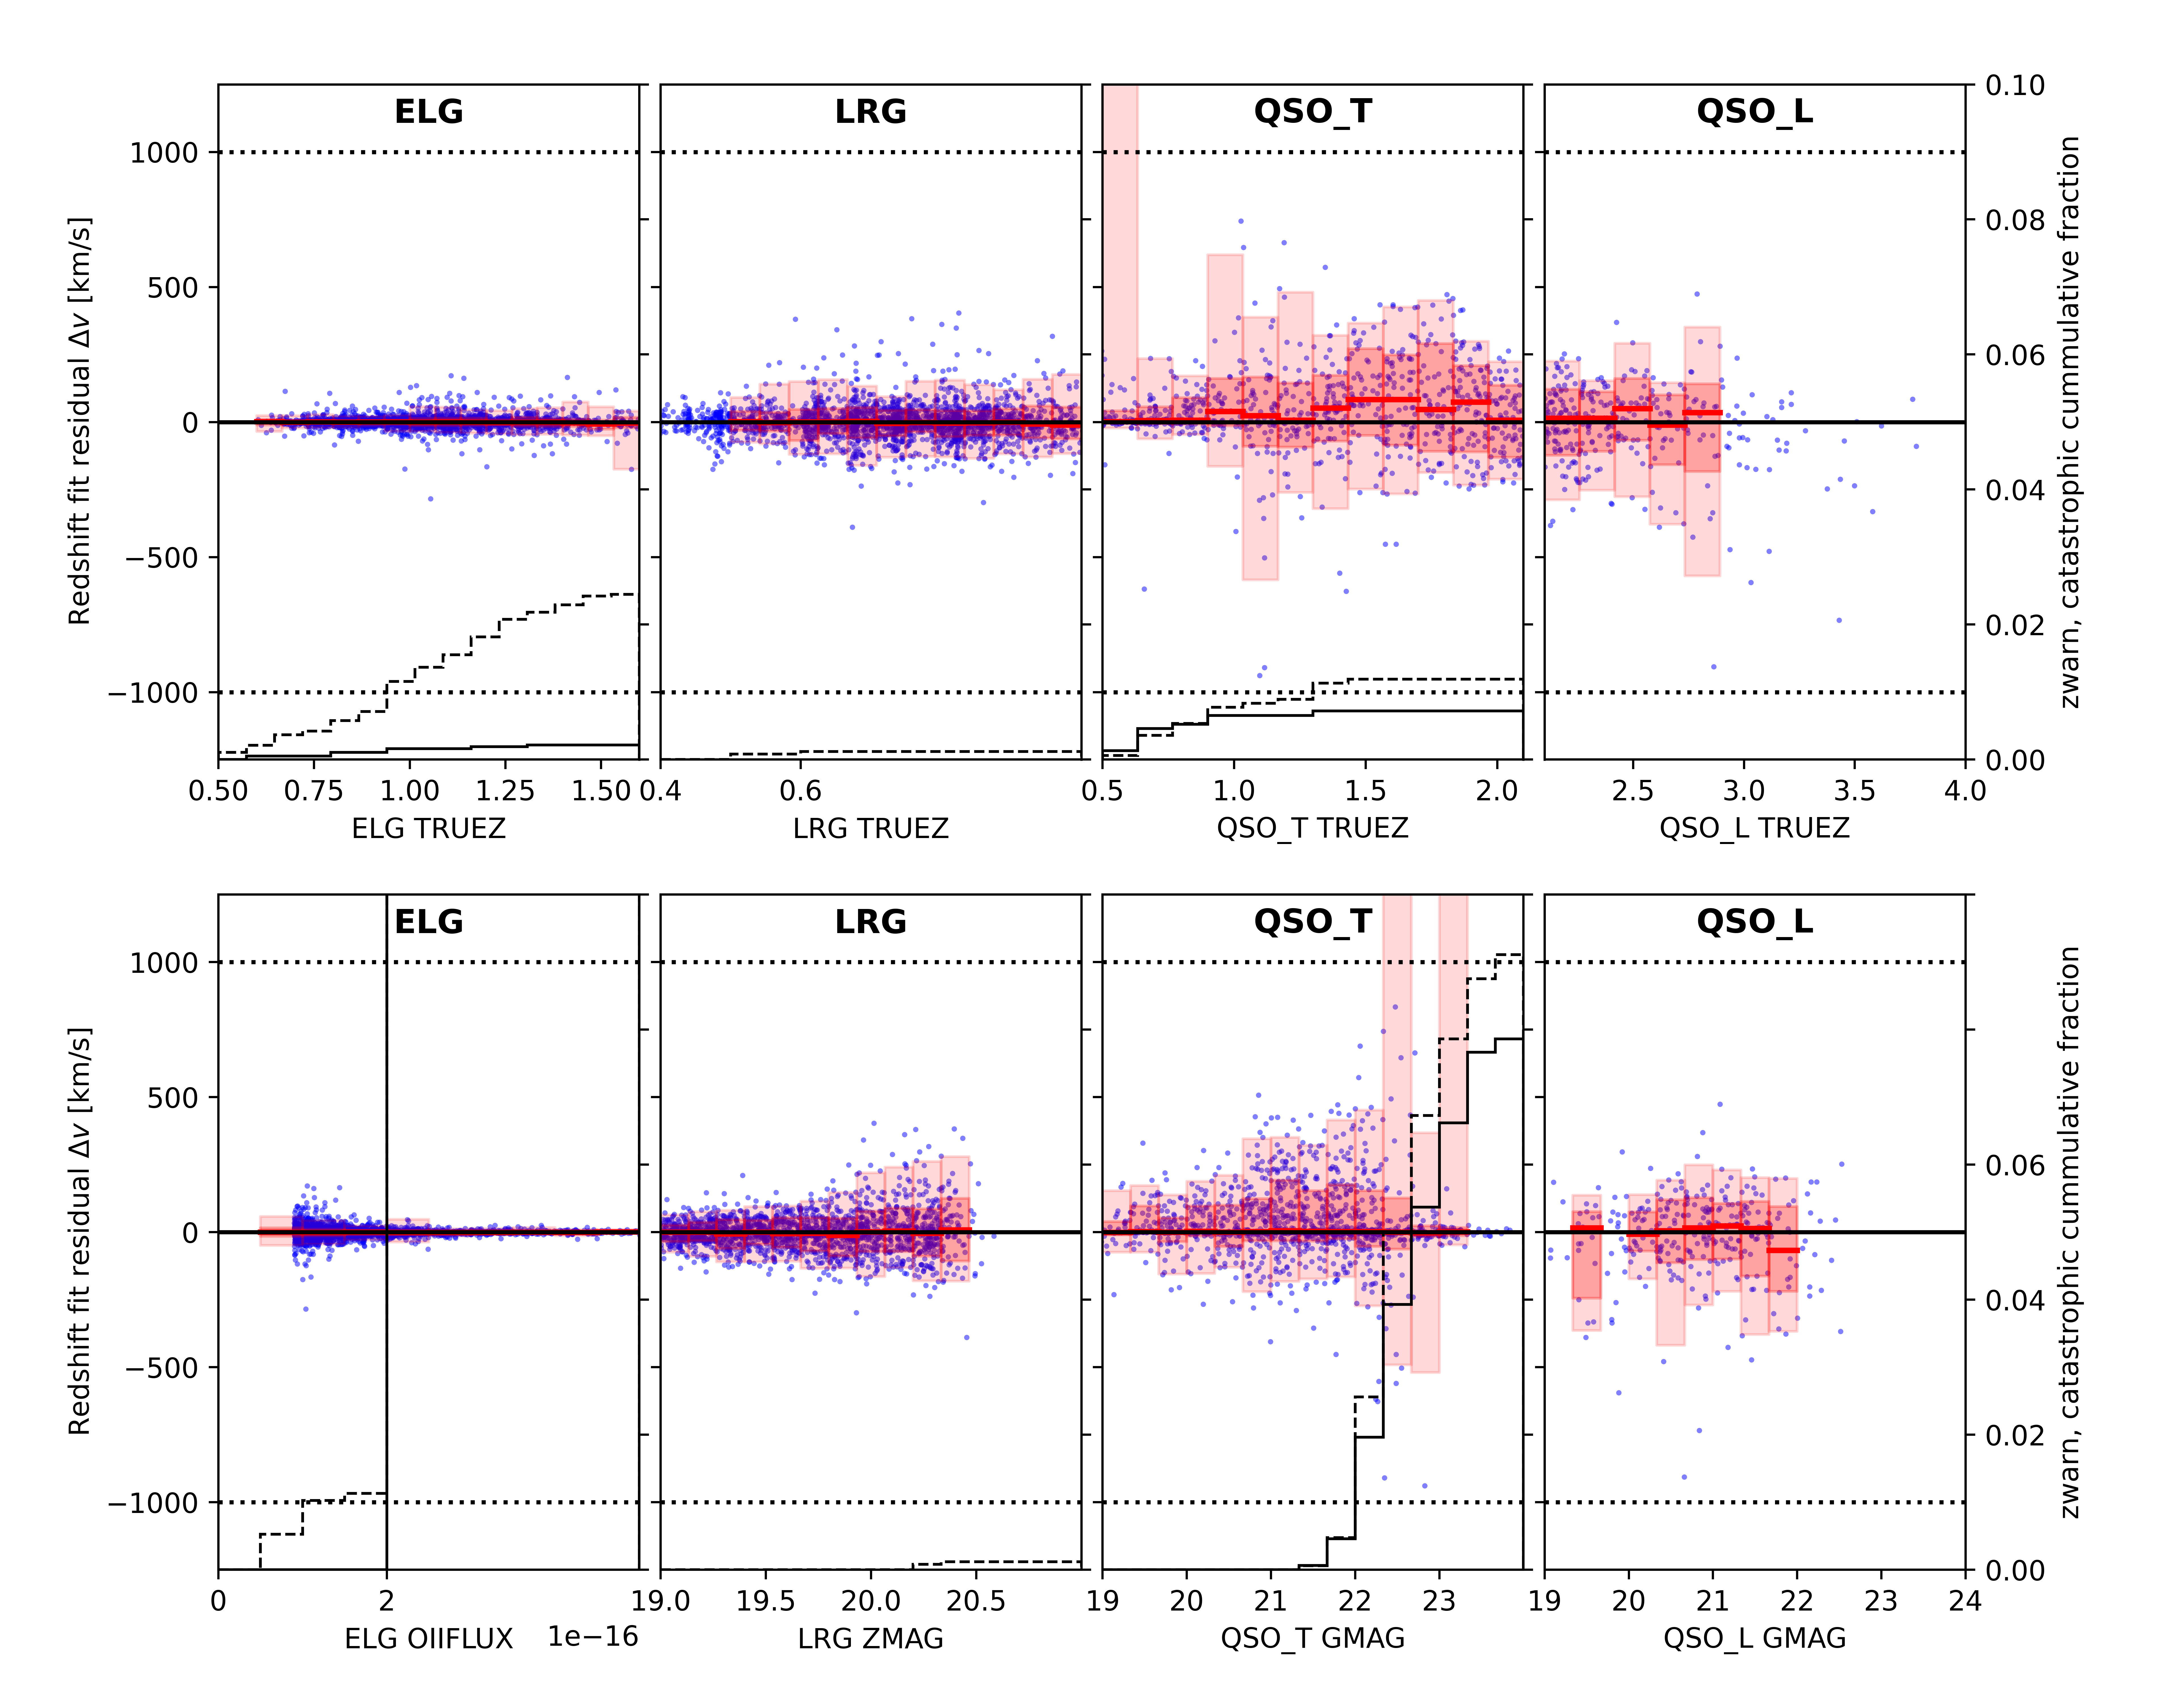

In [83]:
from IPython.display import Image, display
Image(filename=qaprod_dir+'/QA_dzsumm.png') 

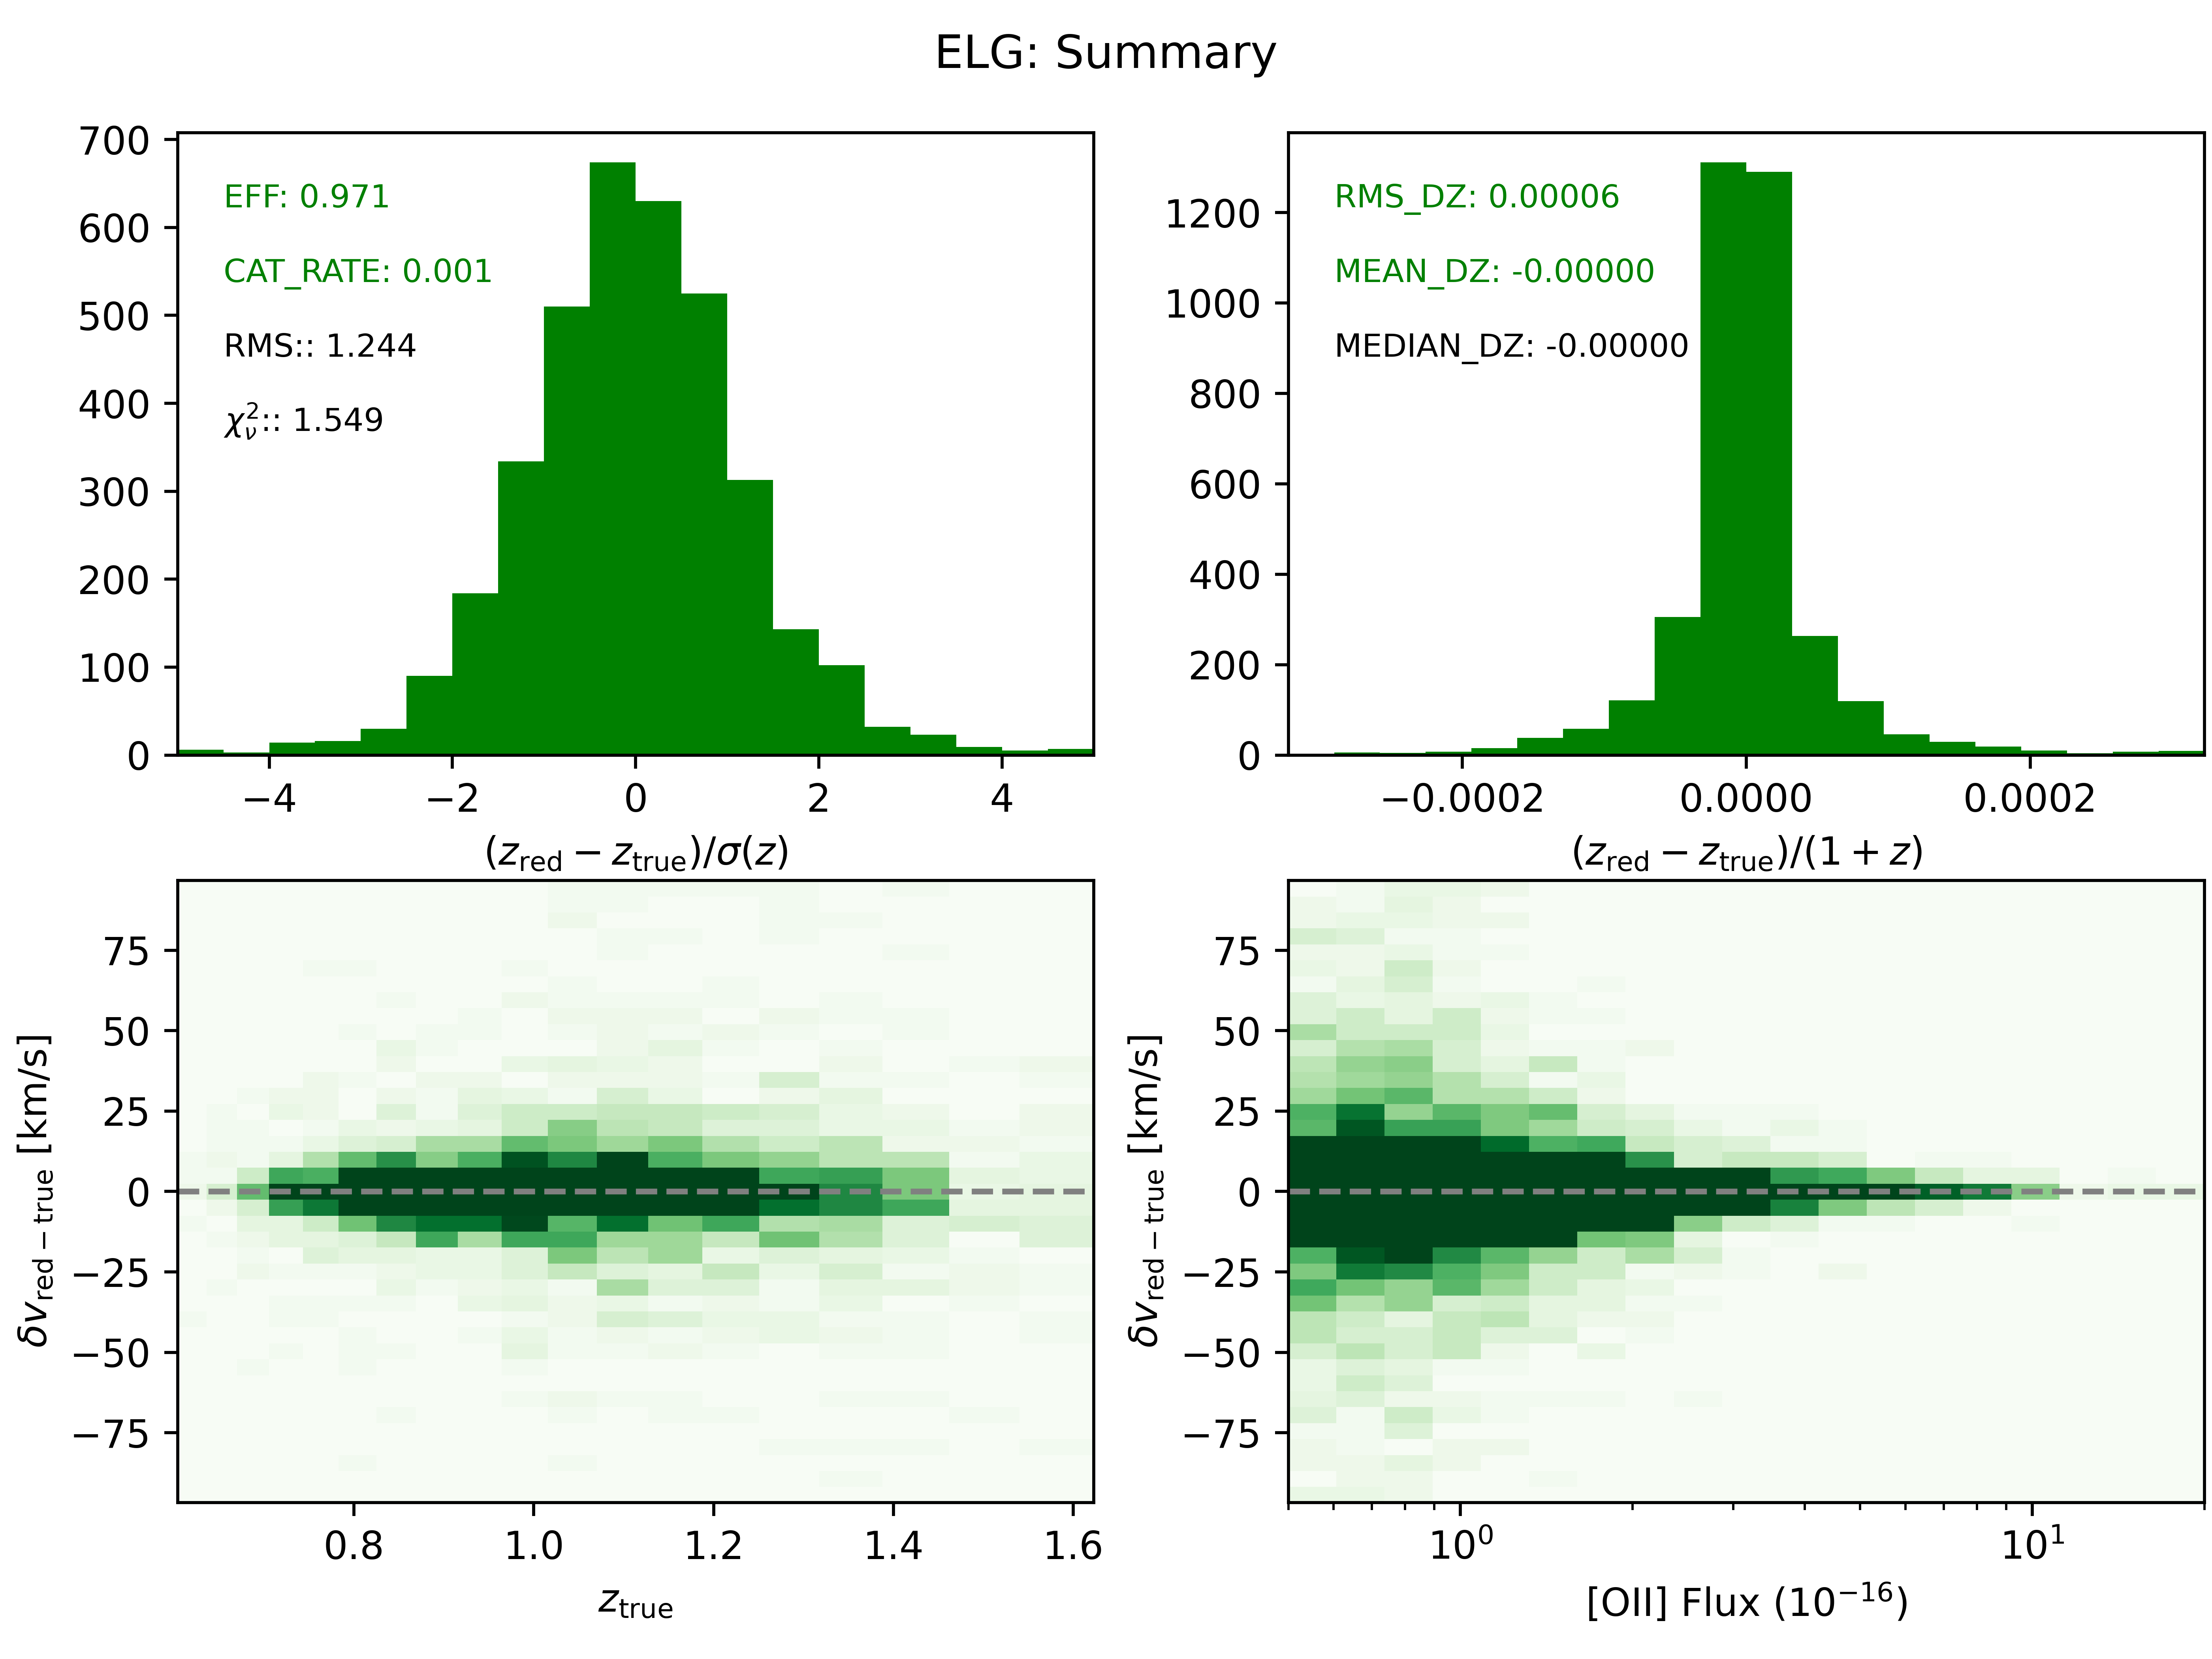

In [84]:
Image(filename=qaprod_dir+'/QA_zfind_ELG.png', width=500)

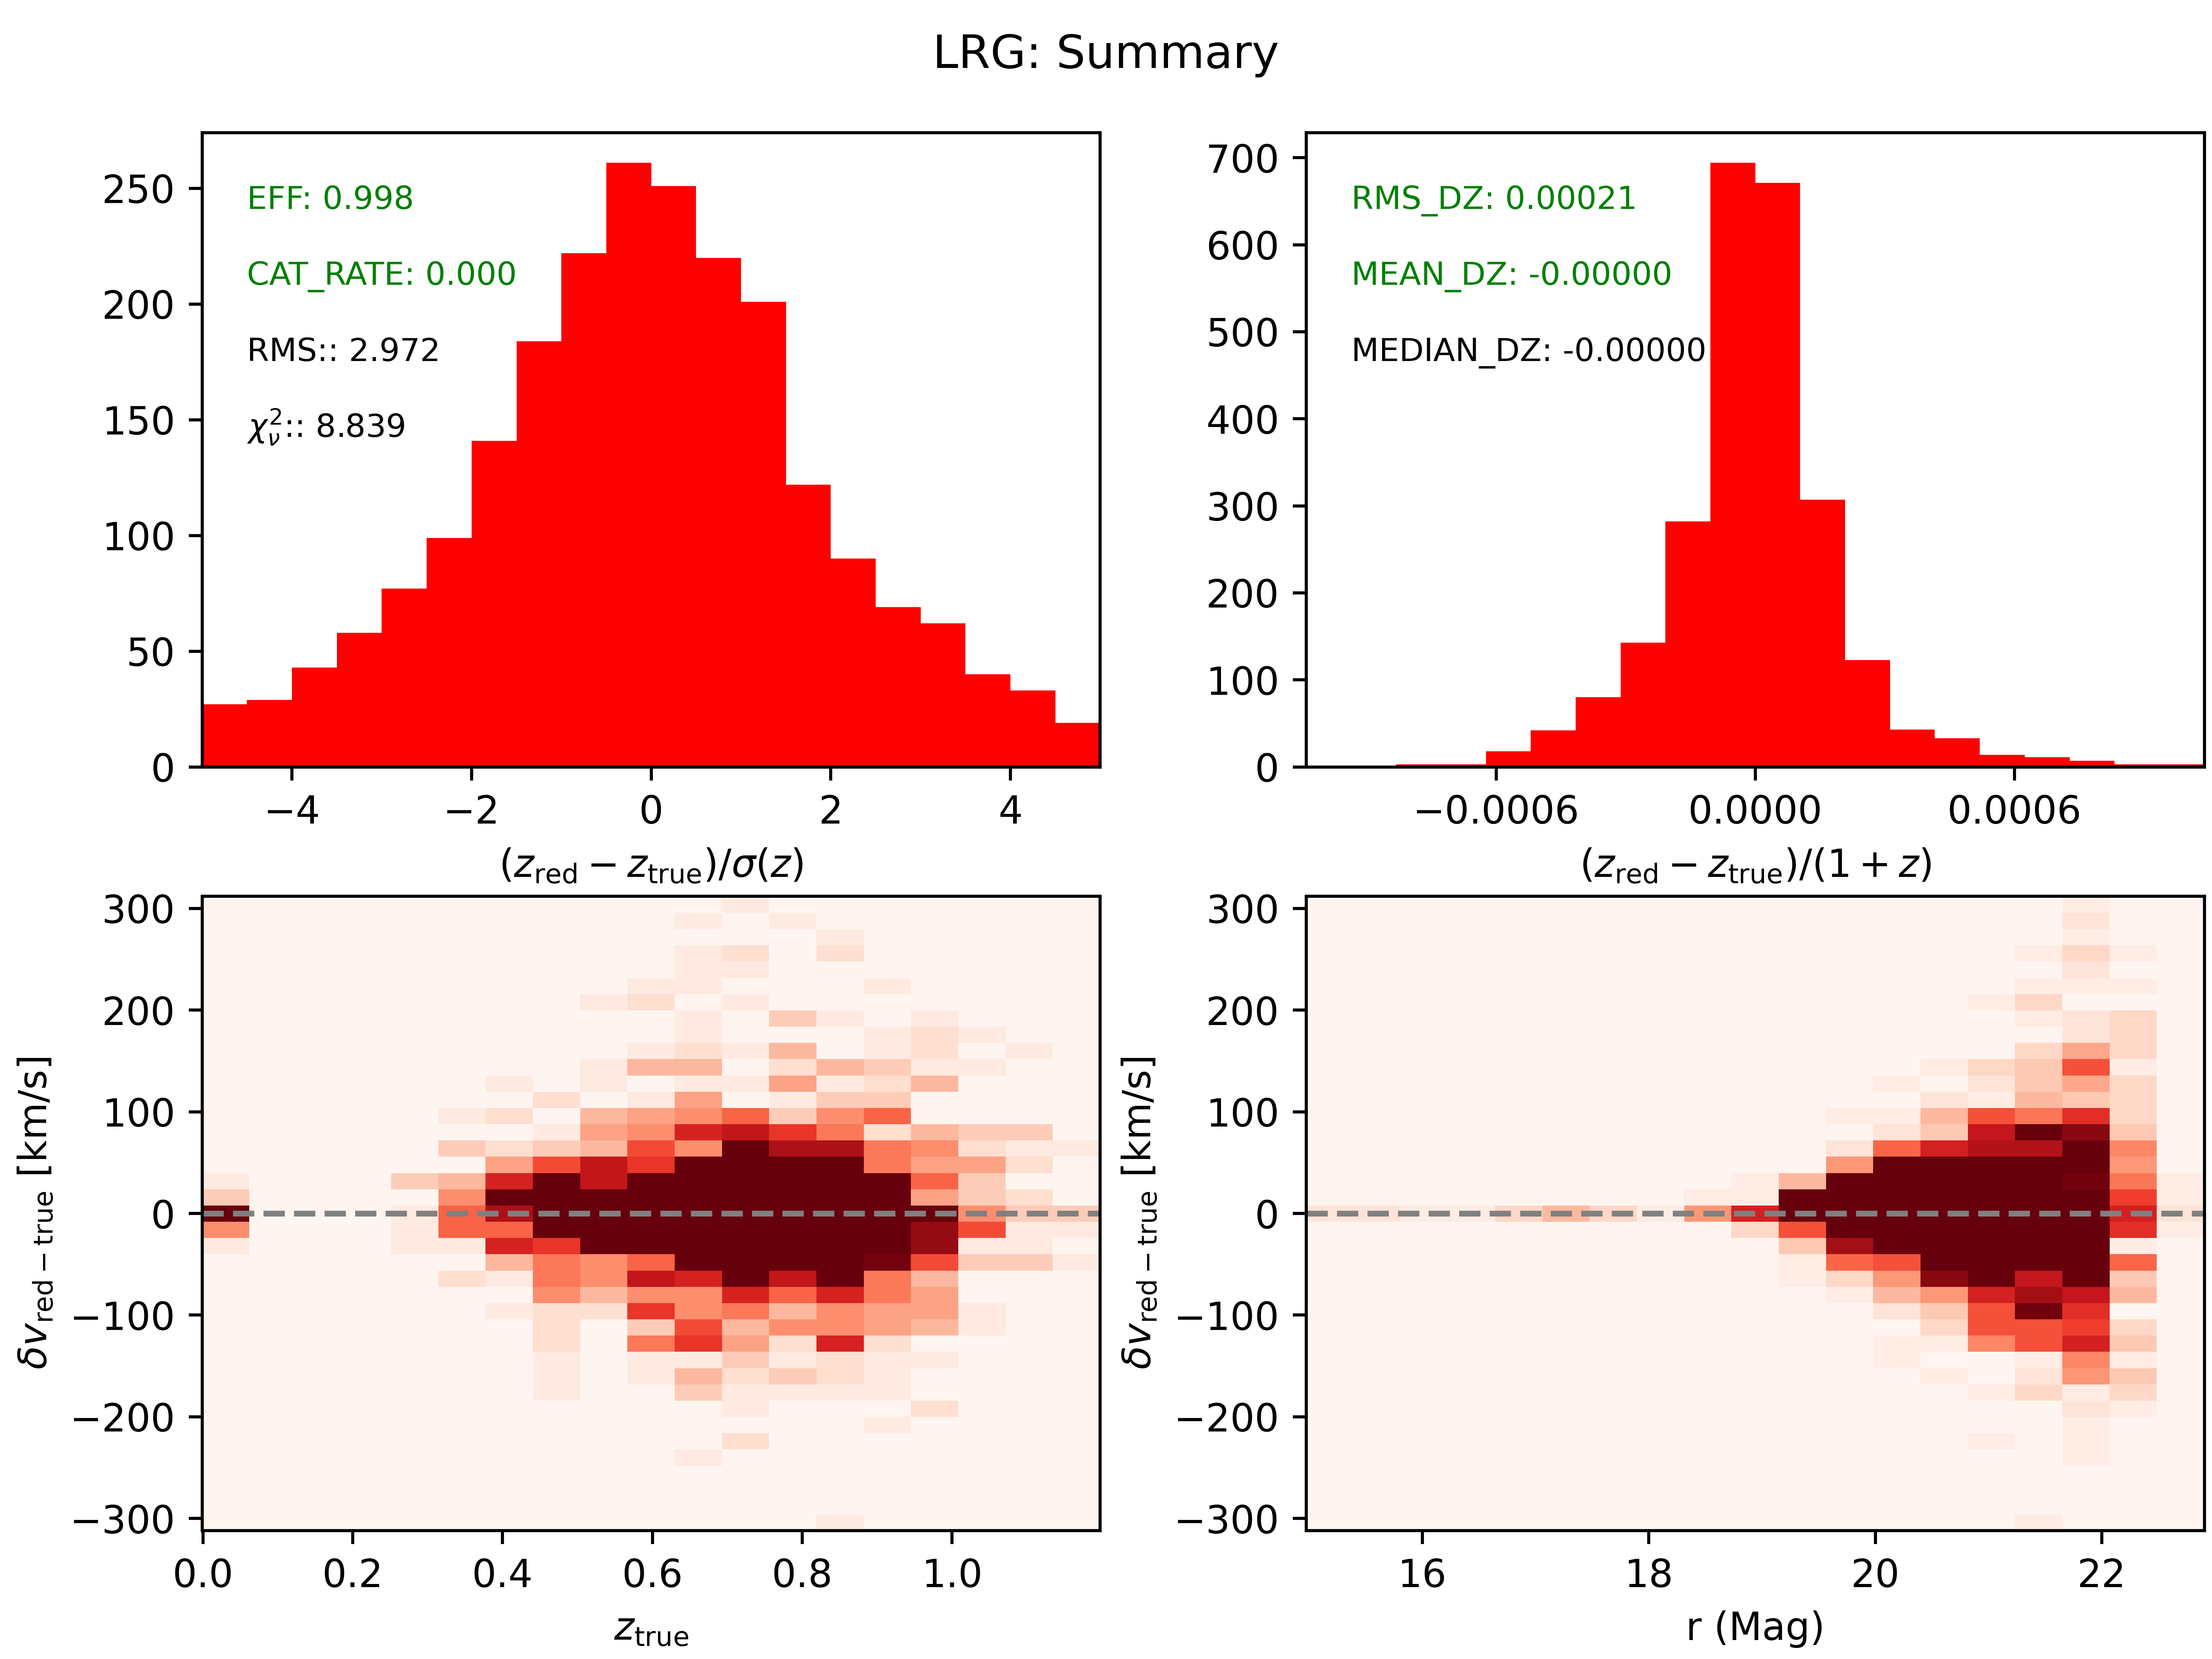

In [85]:
Image(filename=qaprod_dir+'/QA_zfind_LRG.png', width=500)

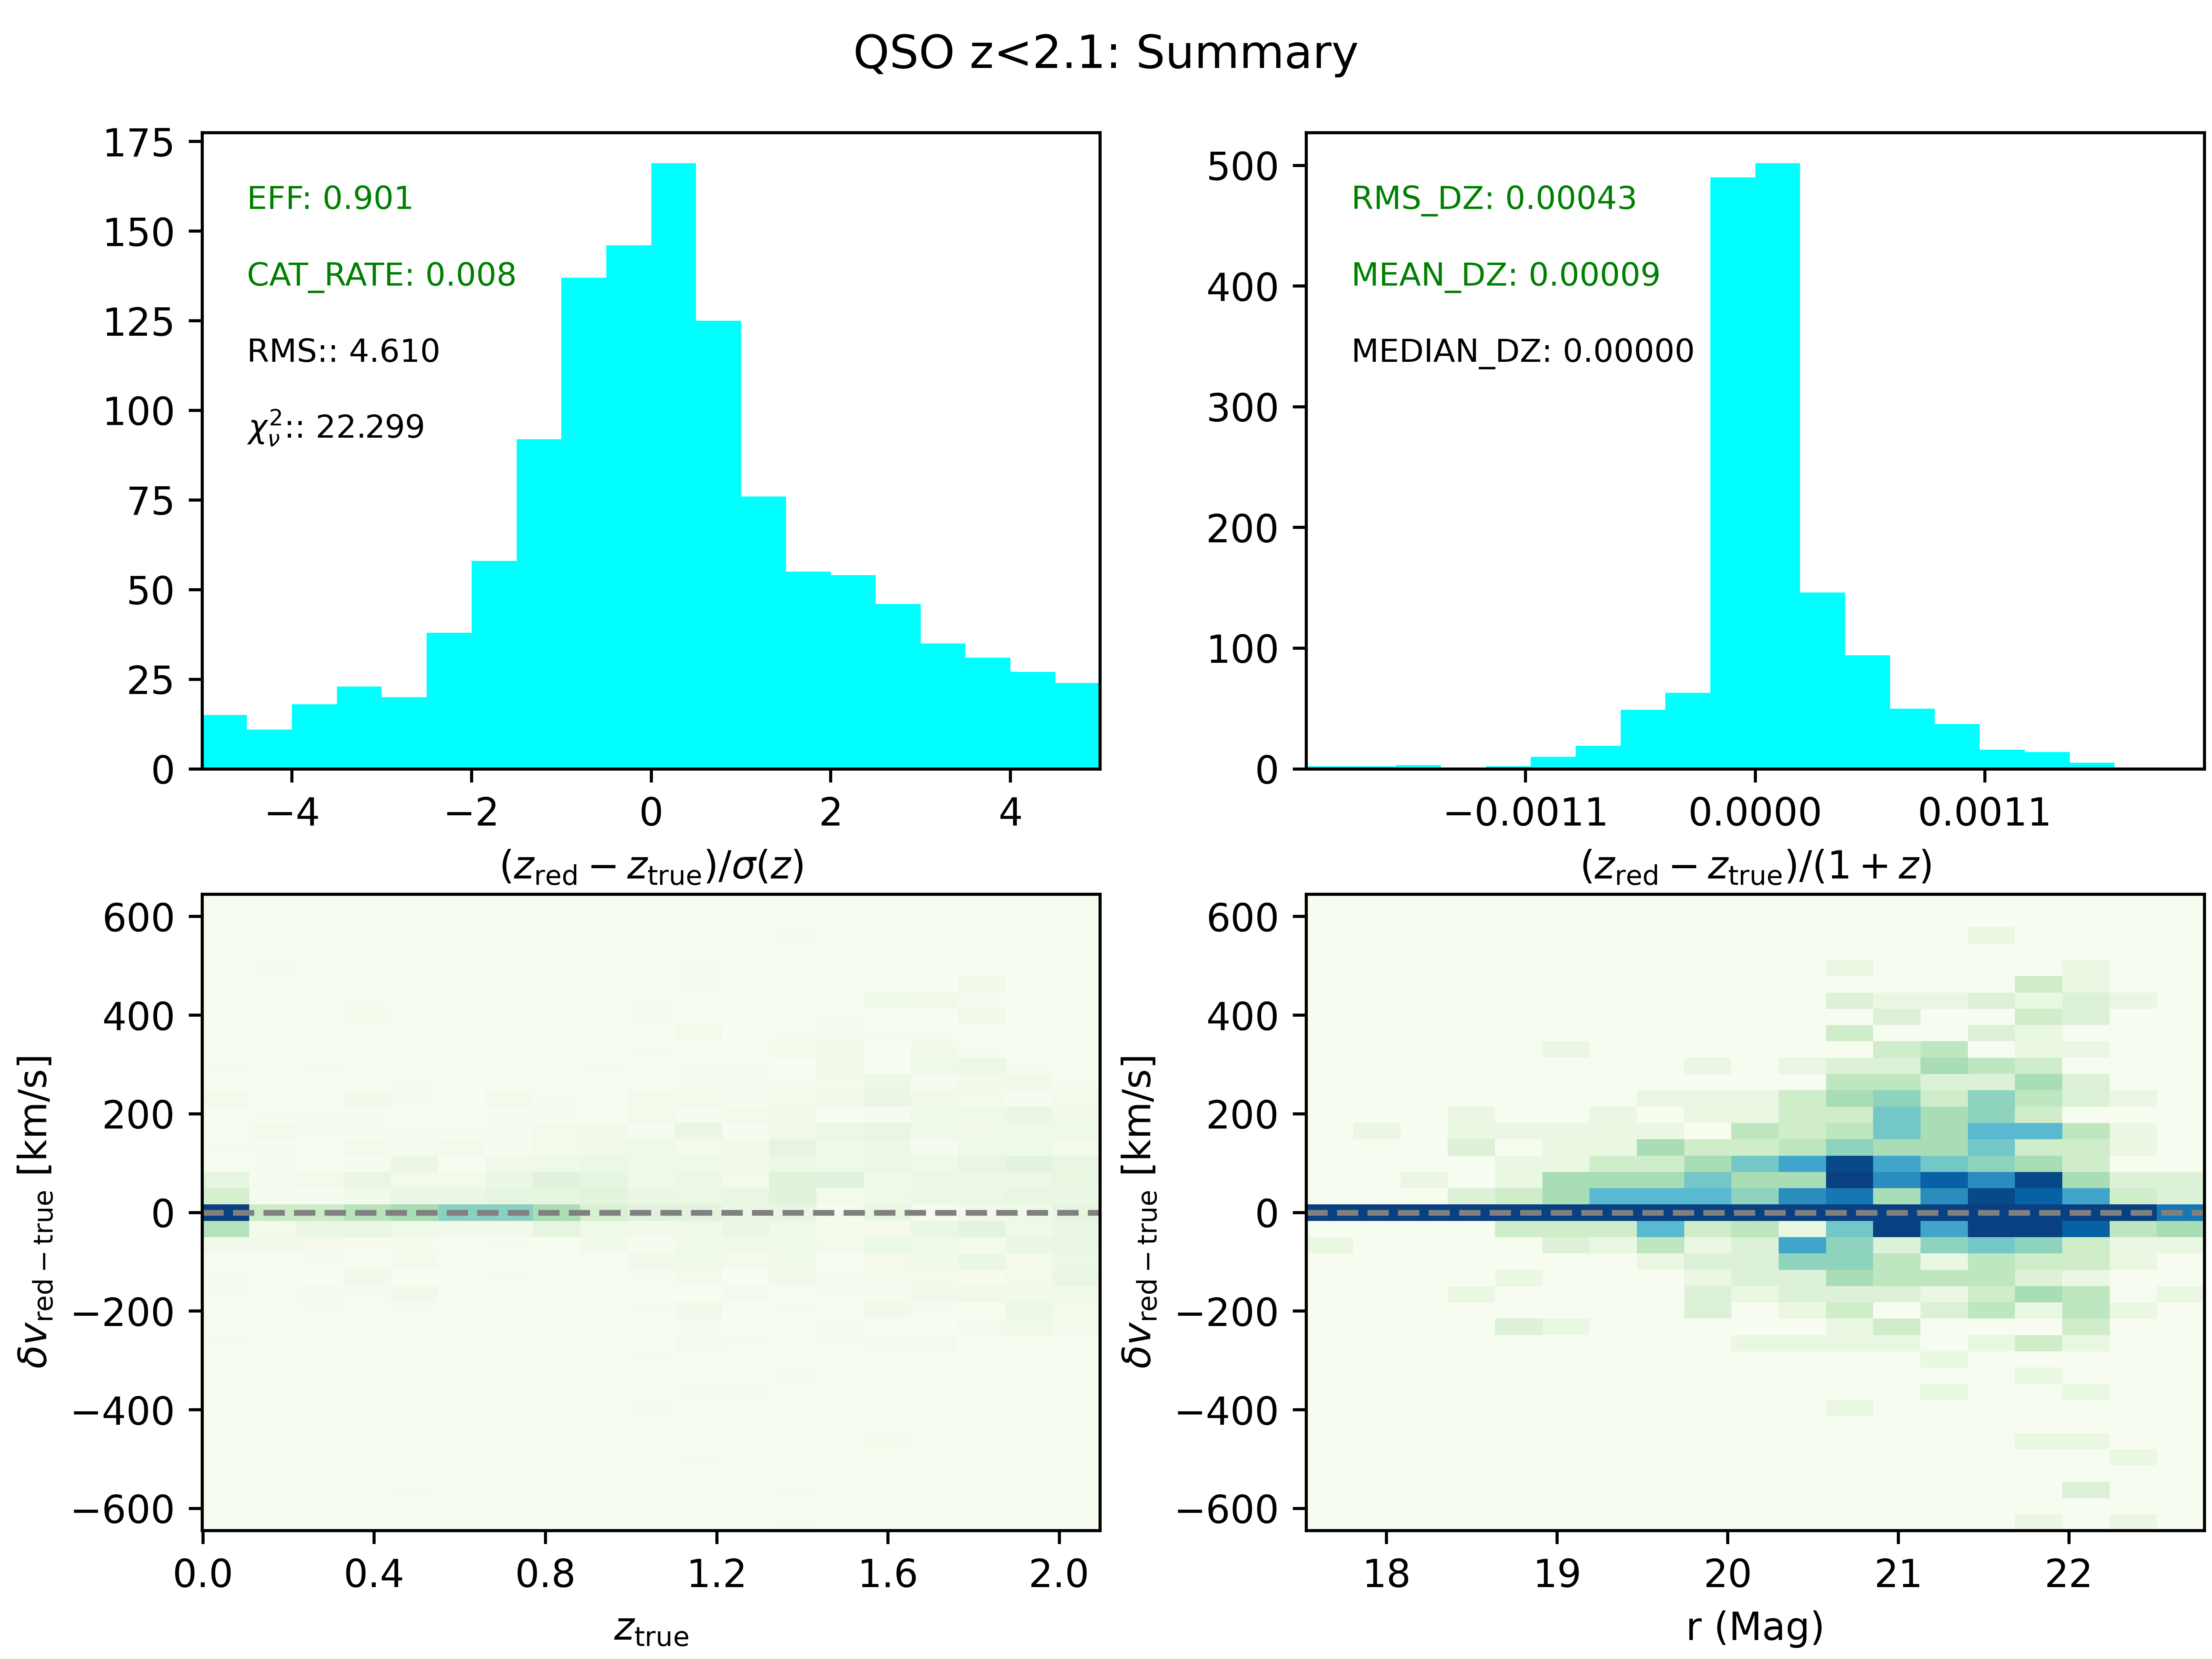

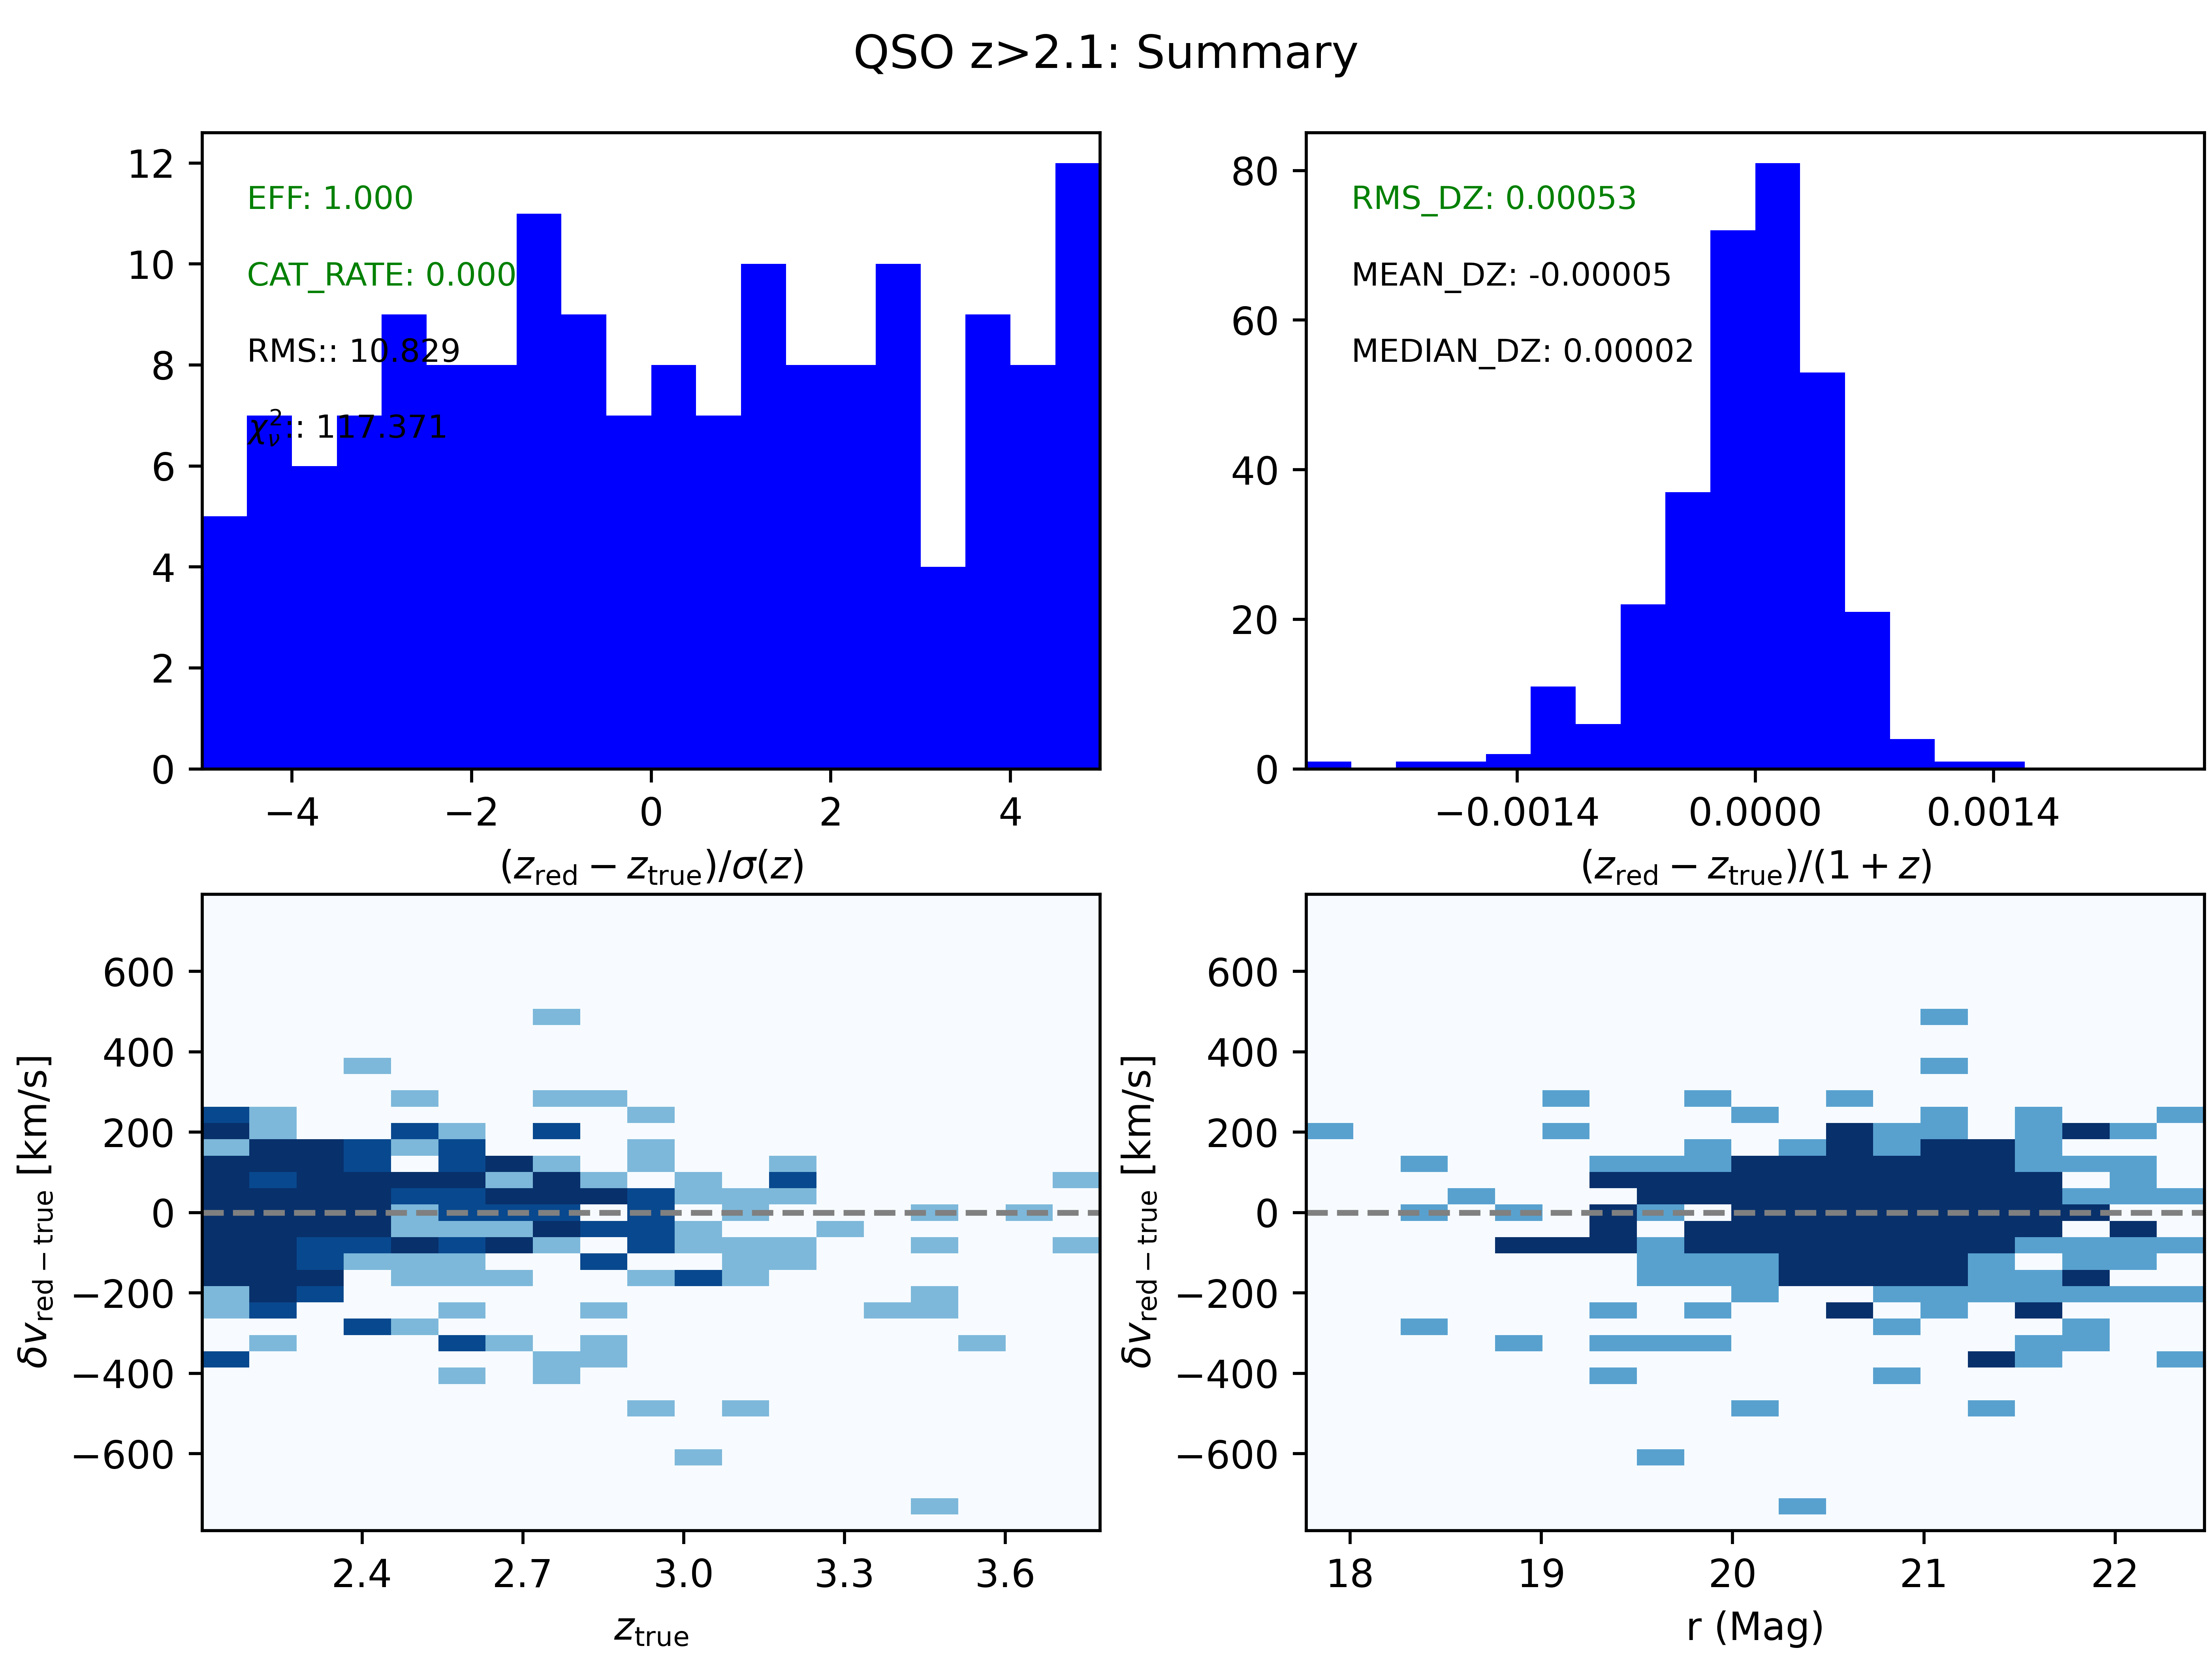

In [86]:
display(
    Image(filename=qaprod_dir+'/QA_zfind_QSO_T.png', width=500),
    Image(filename=qaprod_dir+'/QA_zfind_QSO_L.png', width=500),
)

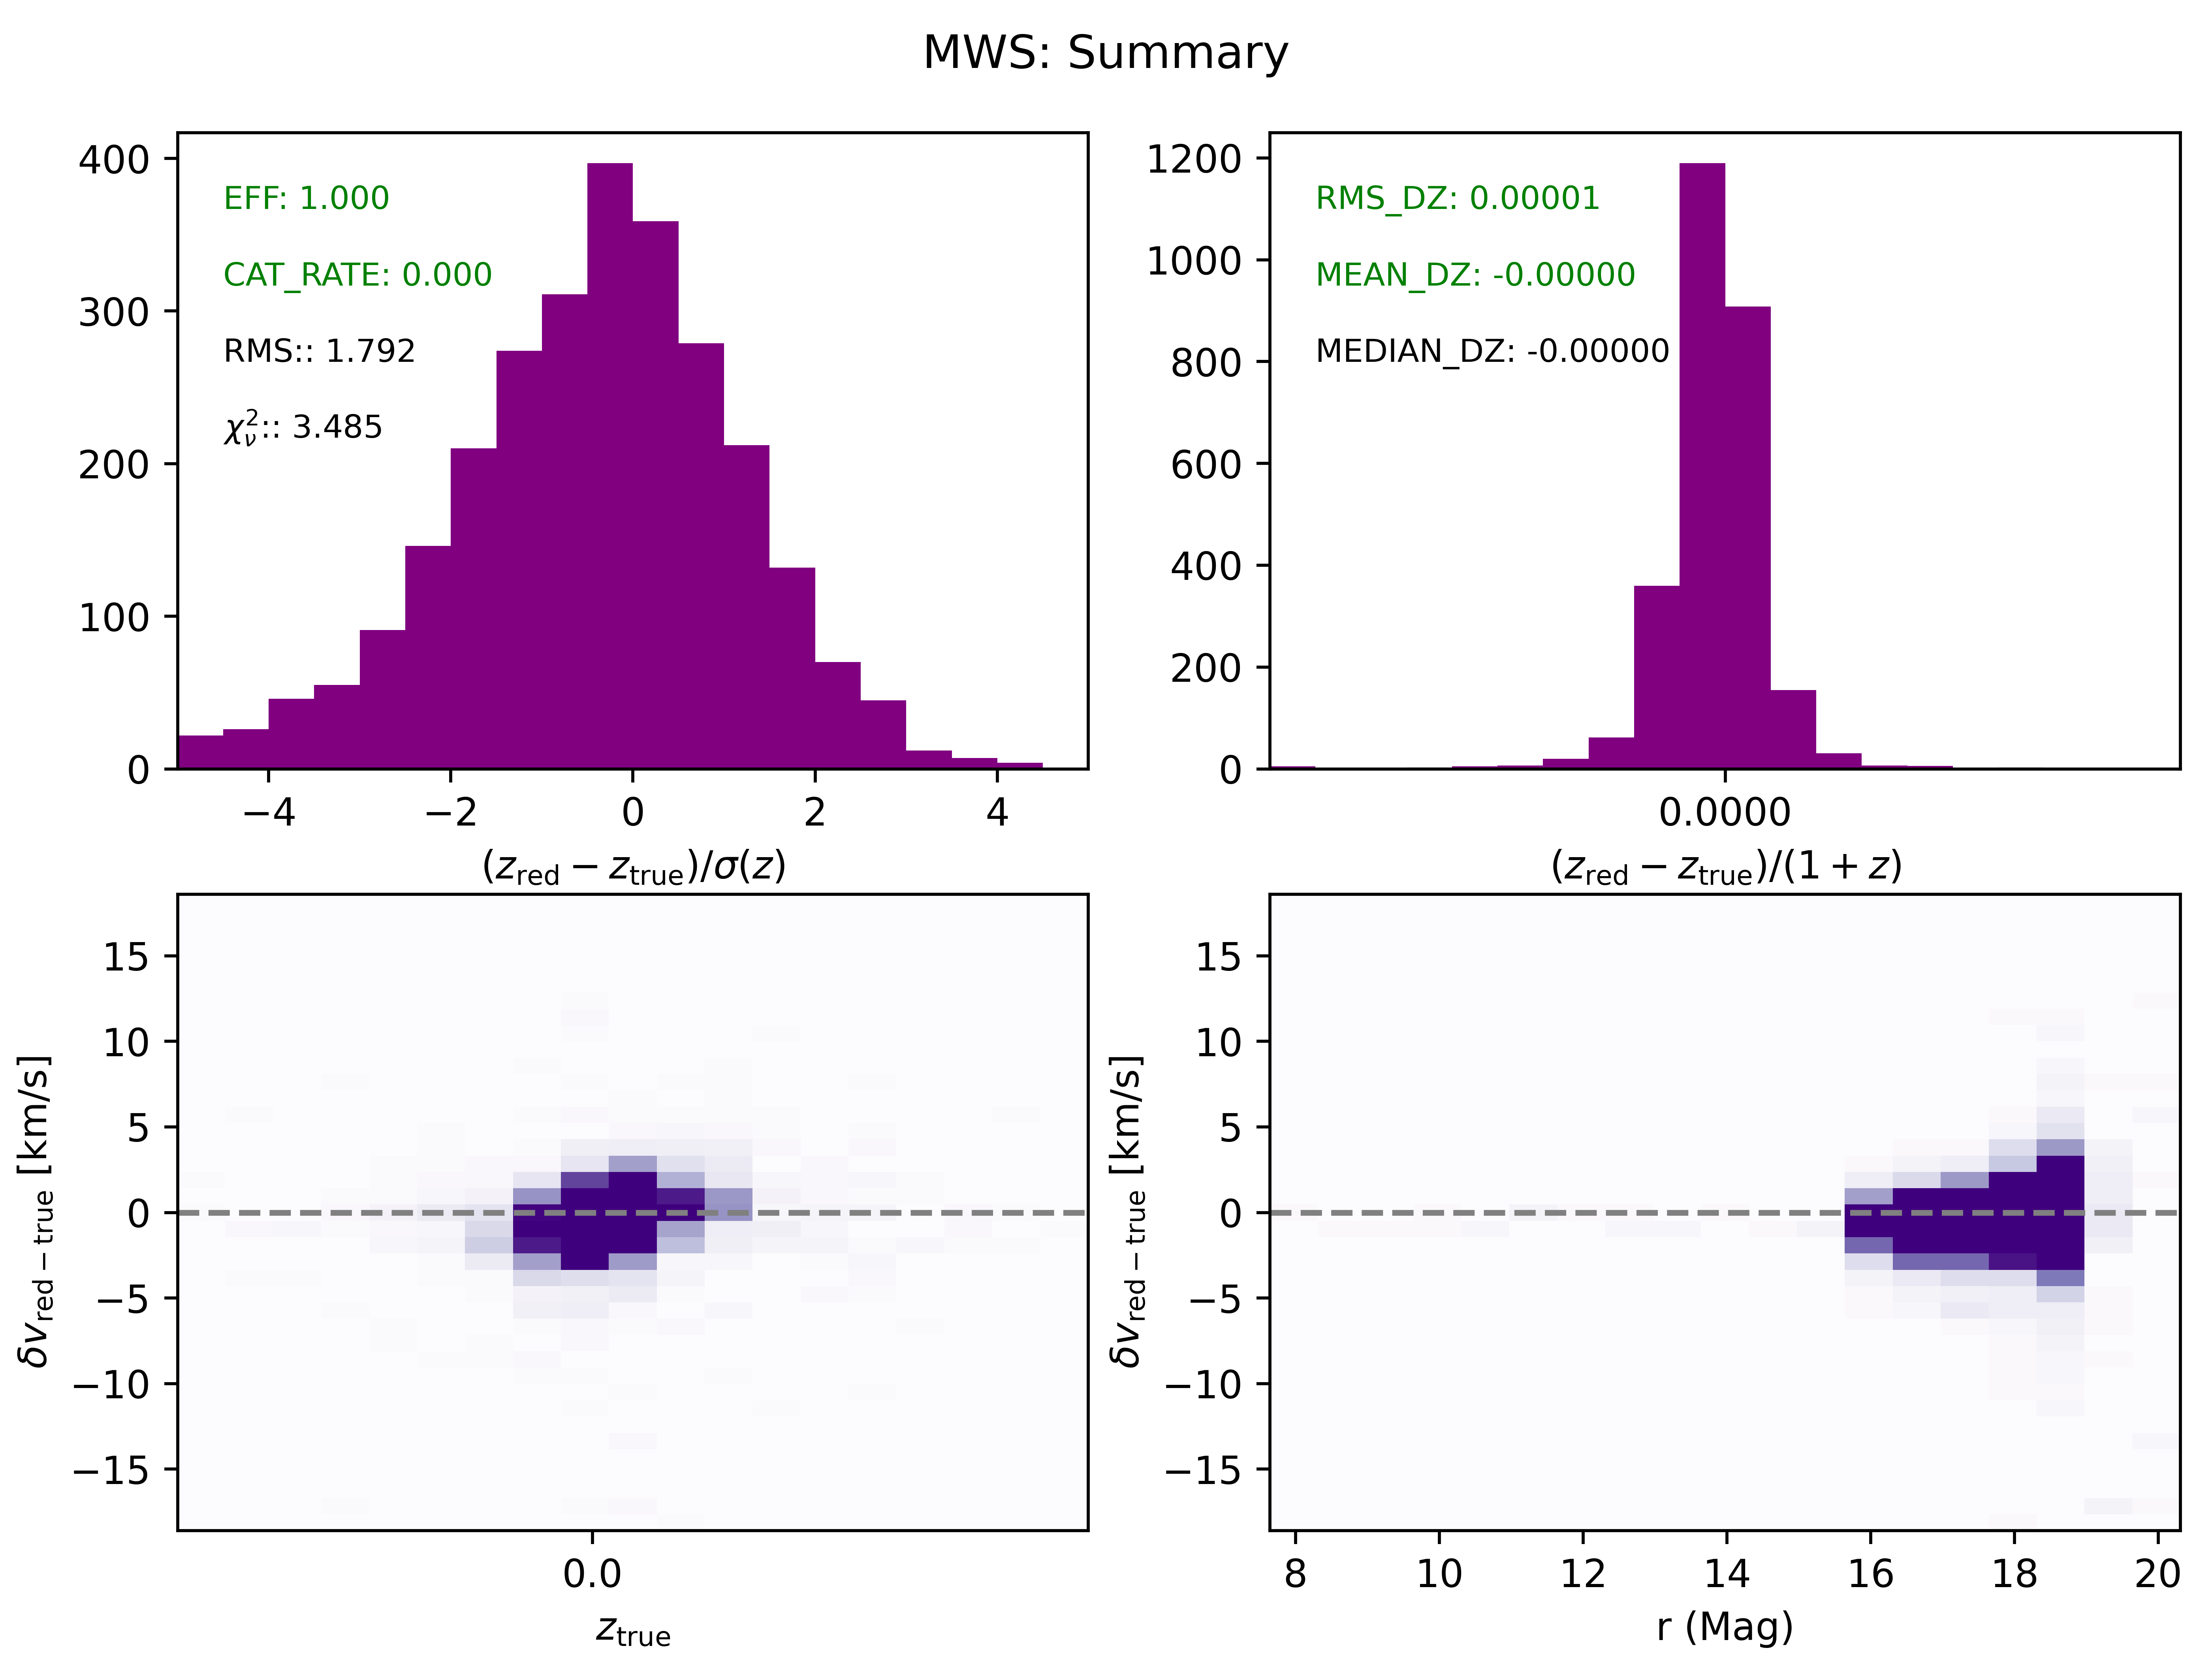

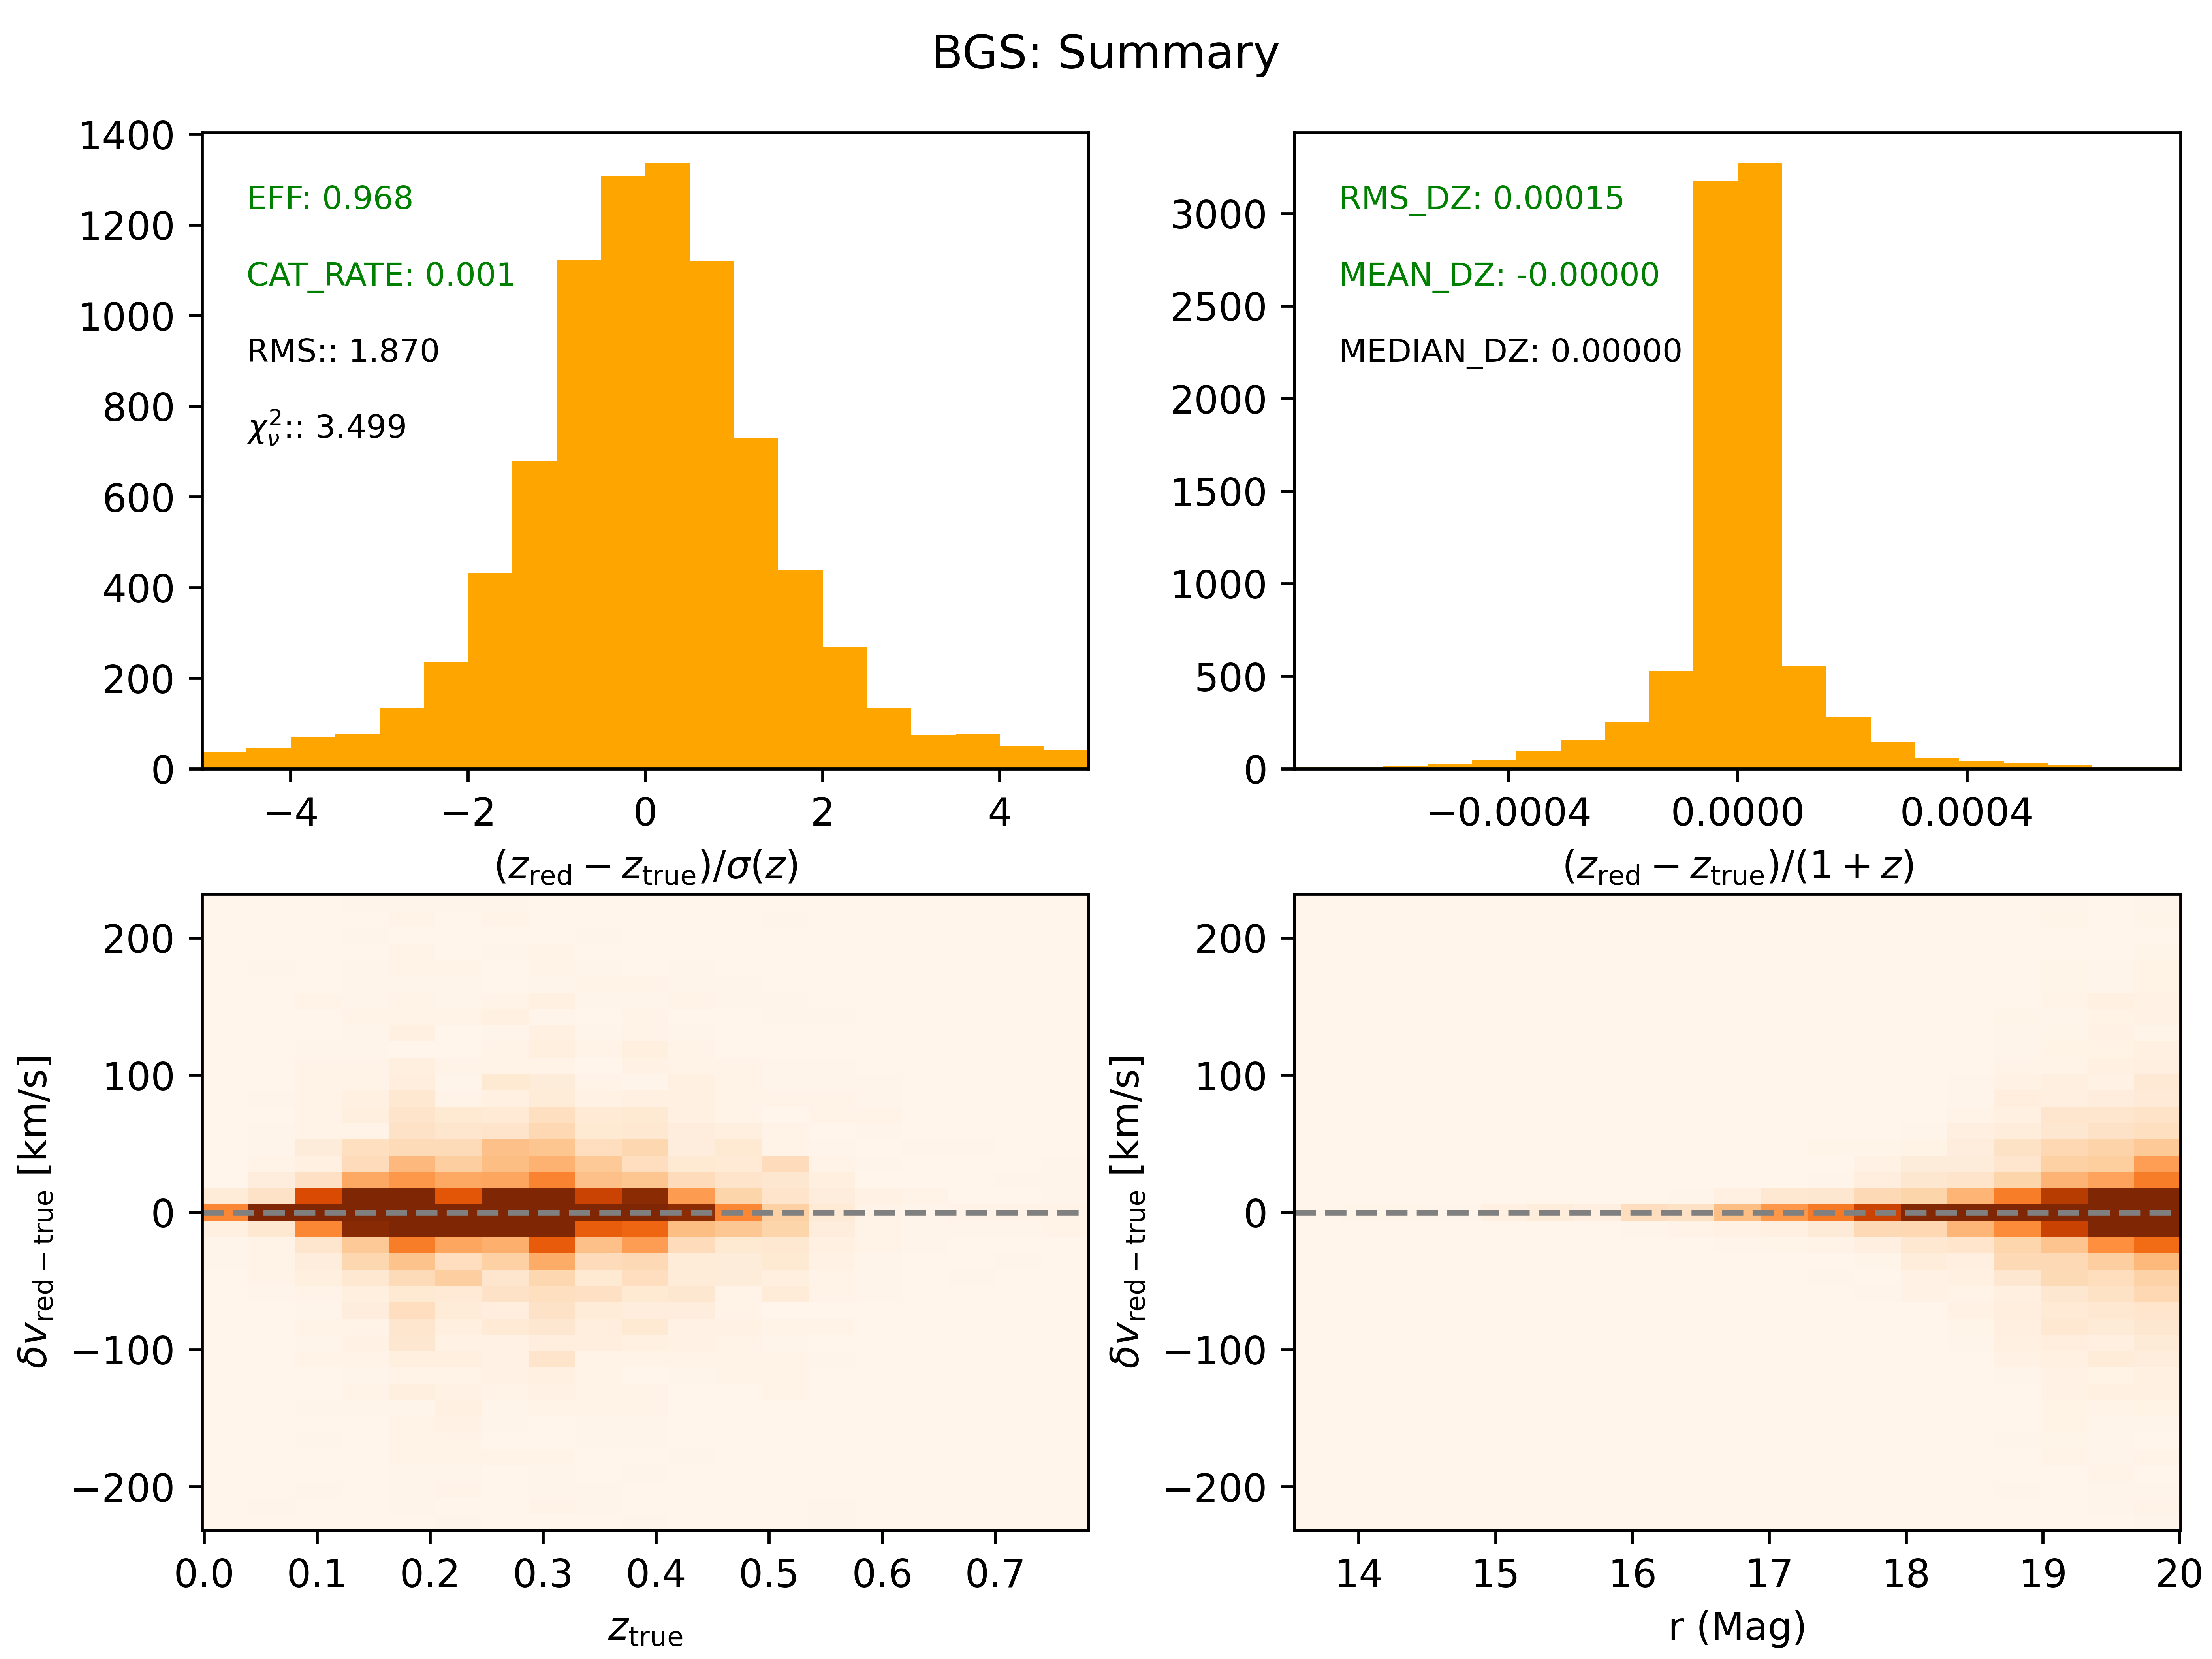

In [87]:
display(
    Image(filename=qaprod_dir+'/QA_zfind_MWS.png', width=500),
    Image(filename=qaprod_dir+'/QA_zfind_BGS.png', width=500),
)

In [88]:
print("Timing checkpoint at {}".format(time.asctime()))
tmp_time = time.time() - notebook_start_time
print("{:.1f} minutes so far".format(tmp_time/60))

Timing checkpoint at Tue Aug  4 23:28:14 2020
74.4 minutes so far


## Offline QA

This can take several hours (!) depending upon $SCRATCH latency

In [89]:
qant_logname = os.path.join(qaprod_dir, 'qa_notruth.log')
print('Logging specto QA to {}'.format(qant_logname))

Logging specto QA to /global/cscratch1/sd/sjbailey/minitest-20.7/spectro/redux/mini/QA/qa_notruth.log


In [ ]:
# Generate the QA (if it doesn't exist already)
qa_start_time = time.time()
with open(qant_logname, 'w') as logfile:
    
    if os.path.exists(qaprod_dir+'/'+os.environ['SPECPROD']+'_qa.json'):
        print("Skipping generating full prod QA file")
    else:
        # Generate yaml files and figures (30min to >1hour depending upon $SCRATCH latency)
        cmd = "desi_qa_prod --make_frameqa=3 --clobber --qaprod_dir={:s}".format(qaprod_dir)  
        print('{} RUNNING {}'.format(time.asctime(), cmd))
        err = subprocess.call(cmd.split(), stdout=logfile, stderr=logfile)
        if err:
            raise RuntimeError('see {}'.format(qant_logname))

        # Slurp (fast)
        cmd = "desi_qa_prod --slurp --qaprod_dir={:s}".format(qaprod_dir)  
        print('{} RUNNING {}'.format(time.asctime(), cmd))
        err = subprocess.call(cmd.split(), stdout=logfile, stderr=logfile)
        if err:
            raise RuntimeError('see {}'.format(qant_logname))
    
    # Skyresid (~8min for the two)
    if len(glob.glob(qaprod_dir+'/skyresid_prod_dual*')) == 3:
        print("Skipping generating SkyResid figures")
    else:
        cmd = "desi_qa_skyresid --prod --qaprod_dir={:s}".format(qaprod_dir)  
        print('{} RUNNING {}'.format(time.asctime(), cmd))
        err = subprocess.call(cmd.split(), stdout=logfile, stderr=logfile)
        if err:
            raise RuntimeError('see {}'.format(qant_logname))

    if len(glob.glob(qaprod_dir+'/skyresid_prod_gauss*')) == 3:
        print("Skipping generating SkyResid Gaussianity figures")
    else:    
        cmd = "desi_qa_skyresid --gauss --qaprod_dir={:s}".format(qaprod_dir)  
        print('{} RUNNING {}'.format(time.asctime(), cmd))
        err = subprocess.call(cmd.split(), stdout=logfile, stderr=logfile)
        if err:
            raise RuntimeError('see {}'.format(qant_logname))
    
    # HTML
    cmd = "desi_qa_prod --html --qaprod_dir={:s}".format(qaprod_dir)
    print('{} RUNNING {}'.format(time.asctime(), cmd))
    err = subprocess.call(cmd.split(), stdout=logfile, stderr=logfile)
    if err:
        raise RuntimeError('see {}'.format(qant_logname))

    
# Time me
print("Done with QA without truth at {}".format(time.asctime()))
qa1_time = time.time() - qa_start_time
print("That took {:.1f} minutes".format(qa1_time/60))

Tue Aug  4 23:28:14 2020 RUNNING desi_qa_prod --make_frameqa=3 --clobber --qaprod_dir=/global/cscratch1/sd/sjbailey/minitest-20.7/spectro/redux/mini/QA


### Check

In [ ]:
# JSON file
prod_qa = desispec.io.qa.load_qa_multiexp(qaprod_dir+'/'+os.environ['SPECPROD']+'_qa')
assert isinstance(prod_qa, dict)
assert len(prod_qa.keys()) == 4
# PNGs
assert len(glob.glob(qaprod_dir+'/skyresid_prod_dual*')) == 3
assert len(glob.glob(qaprod_dir+'/skyresid_prod_gauss*')) == 3
# HTML
assert os.path.exists(qaprod_dir+'/qa-toplevel.html')

### Show

In [ ]:
from IPython.display import Image
Image(filename=qaprod_dir+'/skyresid_prod_dual_r.png')

## Finish Up

In [ ]:
print("Done at {}".format(time.asctime()))
run_time = time.time() - notebook_start_time
print("That took {:.1f} minutes".format(run_time/60))

In [ ]:
# DESI mini end-to-end test

Test end-to-end dataflow using a small number of tiles.<BR/>
pre-testing for 19.12 release, December 2019.